# **CIS 5450 Final Project - Smoking Prediction**
*Amish Sethi, Kerry Zhao, Allison Mi*

# Part 1: Introduction

In this project, we embark on a journey to unravel the intricate connections between biosignals and smoking status through the application of advanced machine learning models. Smoking remains a pervasive public health concern, contributing to a myriad of preventable diseases and impacting individuals and communities worldwide. Understanding the determinants of smoking behavior is crucial for the development of targeted interventions and public health strategies.

To achieve this, we will leverage a diverse set of biosignal data, capturing physiological and behavioral markers, to build predictive models for smoking status. Our primary objective is to discern patterns and correlations within the data that can elucidate the underlying factors influencing an individual's smoking habits. This ambitious undertaking involves the integration of cutting-edge machine learning techniques with comprehensive biosignal datasets.

The core datasets for this project include biosignal recordings, demographic information, and lifestyle data from a diverse cohort of individuals. By assimilating these datasets, we aim to not only predict smoking status accurately but also gain valuable insights into the complex interplay of variables contributing to smoking behavior.

We will aggregate and analyze our biosignal data with meticulous attention to detail. Our approach involves the creation of robust machine learning models capable of discerning subtle patterns and relationships within the data. By employing feature-rich biosignals and advanced algorithms, we anticipate uncovering nuanced insights into the predictors of smoking behavior.

As we delve into our findings, we will present comprehensive visualizations and interpretations, providing a transparent narrative of our analytical journey. Each revelation will be accompanied by a detailed explanation of the motivation behind the analysis, key takeaways, and the implications of our findings on our broader understanding of smoking behaviors.

We invite you to explore the depths of our project and engage with the knowledge we uncover. Your insights and questions will undoubtedly contribute to the refinement and enrichment of our understanding of the intricate dynamics that govern smoking habits, paving the way for more targeted and effective public health interventions.


# Part 2: Data Loading & Preprocessing

##2.1.1 Imports
For this step, we imported relevant machine learning, deep learning, and linear algebra libraries.

In [1]:
# Imports + Installs
!pip install sqlalchemy==1.4.46
!pip install pandasql
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import dask.array as da
import pandasql as ps
from sqlalchemy import create_engine
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn import datasets, linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import warnings
import lightgbm as lgb

warnings.filterwarnings('ignore')

%matplotlib inline


  Using cached pandasql-0.7.3.tar.gz (26 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=ac988dc3599ceb5615902bee6aa24ec5c02a48507c8716d8a5f5dff490302abe
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


###2.2.1 Loading, Analyzing, and Preprocessing Data
Our files were relatively small and quick to upload. As a result, we simply have all four of the files we use stored in the same directory as our code.

Next, we load our core datasets which will contain the data used in our analysis, encapsulating various factors ranging from physiological and behavioral markers to demographic and lifestyle information. Specifically, we will use
* **train_vitals** (information for each individual about quantitative measurements for relaxation, fasting blood sugar, etc.)
* **train_measurements** (various measurements provided per individual)
* **gender_discrimmination** (containing gender, age, weight, and other factors for each individual)
* **smoking datasets** (eyesight, height, if they are a smoker or not, etc.)

and compare various factors across these datasets.

Here, we load the following 4 datasets into our environment. Each dataset, ranging from vital health metrics to gender-specific insights, will help us gather data about smoking habits.


In [3]:
# Load the dataset
train_vitals_data = pd.read_csv('train_vitals.csv')
train_measurements_data = pd.read_csv('train_measurements.csv')
gender_data = pd.read_csv('gender_discrimination.csv')
train_smoking_data = pd.read_csv('smoking.csv')
train_vitals_data.head()

id  systolic  relaxation  fasting blood sugar  Cholesterol  triglyceride  \
0   0       135          87                   94          172           300   
1   1       146          83                  147          194            55   
2   2       118          75                   79          178           197   
3   3       131          88                   91          180           203   
4   4       121          76                   91          155            87   

   HDL  LDL  hemoglobin  Urine protein  serum creatinine  AST  ALT  Gtp  \
0   40   75        16.5              1               1.0   22   25   27   
1   57  126        16.2              1               1.1   27   23   37   
2   45   93        17.4              1               0.8   27   31   53   
3   38  102        15.9              1               1.0   20   27   30   
4   44   93        15.4              1               0.8   19   13   17   

   dental caries  smoking  
0              0        1  
1              1        0  
2              0        1  
3              1        0  
4              0        1

By printing out the head, we gain insight into the first 5 rows of the dataset (where each row represents a person) the various data found corresponding to that individual. Our train_data has 24 columns total while our gender_data is a subset of this with only 12 columns.

In [4]:
#This prints the first 5 rows of the dataset gender_discrimmination
gender_data.head()

ID gender  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0      F   40         155          60       81.3             1.2   
1   1      F   40         160          60       81.0             0.8   
2   2      M   55         170          60       80.0             0.8   
3   3      M   40         165          70       88.0             1.5   
4   4      F   40         155          60       86.0             1.0   

   eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
0              1.0              1               1       114          73   
1              0.6              1               1       119          70   
2              0.8              1               1       138          86   
3              1.5              1               1       100          60   
4              1.0              1               1       120          74   

   fasting blood sugar  Cholesterol  triglyceride  
0                   94          215            82  
1                  130          192           115  
2                   89          242           182  
3                   96          322           254  
4                   80          184            74

#Part 3. Data Preprocessing

##3.1.1 Convert Columns Names
We begin by standardizing the column names across both our datasets, 'train_measurements_data' and 'train_vitals_data'. This process ensures that our columns can be comparable across various datasets, maintaining uniformity across different datasets but also simplifying data querying and manipulation.

In [5]:
# In our data preprocessing, we convert to a standardized format, first
#converting the column names to lowercase

train_measurements_data.columns = train_measurements_data.columns.str.lower()
train_vitals_data.columns = train_vitals_data.columns.str.lower()

##3.1.2 Feature Engineering
In this phase of our data processing, we engage in feature engineering to extract and create meaningful metrics that can provide deeper insights into the relationships within our data. With categorical variables, they all only have exactly two possibilities,
so those will be the only possible values for encoding.

* **Height to Weight Ratio:** We introduce the 'height_to_weight_ratio' by dividing height by weight, offering a basic yet informative perspective on body proportionality.

* **Body Mass Index (BMI):** The BMI is calculated, providing a standardized measure of body weight relative to height, a vital indicator of overall health status.

* **Waist to Height Ratio (WHtR):** We compute the 'waist_to_height_ratio', an important metric in assessing central obesity and associated health risks.

* **Normalized Vision:** Both 'eyesight(left)' and 'eyesight(right)' are normalized to a scale of 0 to 1, with the highest diopter being 9.9, allowing for a more standardized comparison of vision metrics.

* **Average Normalized Vision:** We calculate 'avg_vision' as the mean of normalized left and right eyesight, providing an aggregated view of visual health.

* **Normalized Hearing:** Hearing data for both ears is normalized to values 0 or 1, facilitating a binary representation of hearing ability.

* **Average Hearing:** The 'avg_hearing' is computed as the average of left and right hearing, offering an overall assessment of auditory health.

In [ ]:
#converts columns to lowercase
train_measurements_data.columns = train_measurements_data.columns.str.lower()
train_vitals_data.columns = train_vitals_data.columns.str.lower()

In [6]:
#Creating new columns relevant to potential factors of smoking

#height to weight column
train_measurements_data['height_to_weight_ratio'] = train_measurements_data['height(cm)'] / train_measurements_data['weight(kg)']

#body mass index (BMI)
train_measurements_data['bmi'] = train_measurements_data['weight(kg)'] / ((train_measurements_data['height(cm)'] / 100) ** 2)

#waist to height ratio (WHtR)
train_measurements_data['waist_to_height_ratio'] = train_measurements_data['waist(cm)'] / train_measurements_data['height(cm)']

#vision (normalized 0 to 1, with highest diopter 9.9)
train_measurements_data['eyesight(left)'] = train_measurements_data['eyesight(left)'] / 9.9
train_measurements_data['eyesight(right)'] = train_measurements_data['eyesight(right)'] / 9.9

#average normalized vision
train_measurements_data['avg_vision'] = (train_measurements_data['eyesight(left)'] + train_measurements_data['eyesight(right)']) / 2


#normalized hearing to have vals 0 or 1
train_measurements_data['hearing(right)'] = train_measurements_data['hearing(right)'] - 1
train_measurements_data['hearing(left)'] = train_measurements_data['hearing(left)'] - 1

#average hearing (normalized 0 to 1)
train_measurements_data['avg_hearing'] = (train_measurements_data['hearing(left)'] + train_measurements_data['hearing(right)']) / 2






##3.1.3 Merging Two Datasets
We now merge 'train_measurements_data' with 'train_vitals_data', aligning them on shared 'id' and 'smoking' columns. An additional feature, 'ldl_to_hdl_ratio' is created by dividing LDL cholesterol levels by HDL cholesterol levels. This ratio is a significant indicator in medical studies, often used to assess the risk of cardiovascular diseases.

These were two datasets we found each giving us separte features. One provided the measurement (height, weight, etc) while the other gave us specfically vitals.

In [139]:
#Merging train_measurements_data with train_vitals_data
train_data = pd.merge(train_measurements_data, train_vitals_data, on=['id','smoking'])
smoking_column = train_data['smoking']

#Dropping Smoking Column
train_data = train_data.drop(columns = ['smoking'])
train_data['smoking'] = smoking_column

#Creating LDL to HDL Ratio
train_data['ldl_to_hdl_ratio'] = train_data['ldl'] / train_data['hdl']
train_data.head()

id  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0   55         165          60       81.0        0.050505   
1   1   70         165          65       89.0        0.060606   
2   2   20         170          75       81.0        0.040404   
3   3   35         180          95      105.0        0.151515   
4   4   30         165          60       80.5        0.151515   

   eyesight(right)  hearing(left)  hearing(right)  height_to_weight_ratio  \
0         0.060606              0               0                2.750000   
1         0.070707              1               1                2.538462   
2         0.050505              0               0                2.266667   
3         0.121212              0               0                1.894737   
4         0.101010              0               0                2.750000   

   ...  ldl  hemoglobin  urine protein  serum creatinine  ast  alt  gtp  \
0  ...   75        16.5              1               1.0   22   25   27   
1  ...  126        16.2              1               1.1   27   23   37   
2  ...   93        17.4              1               0.8   27   31   53   
3  ...  102        15.9              1               1.0   20   27   30   
4  ...   93        15.4              1               0.8   19   13   17   

   dental caries  smoking  ldl_to_hdl_ratio  
0              0        1          1.875000  
1              1        0          2.210526  
2              0        1          2.066667  
3              1        0          2.684211  
4              0        1          2.113636  

[5 rows x 30 columns]

##3.2.1 Adding Gender As a Column
When exploring the connection between biosignals and smoking habits, it's critical to consider gender as it could significantly influence the analysis. Ignoring gender might result in skewed or inaccurate interpretations, as it could mask the actual relationship between biosignals and smoking behaviors, a potential confounding factor. Including gender as a covariate in the analysis is therefore crucial for achieving a more precise and reliable understanding of how biosignals relate to smoking patterns. In this study, we aim to ascertain gender using indicators like height, weight, waist size, blood pressure, and others, integrating this information with another dataset to enhance the accuracy of gender prediction within our data.

We again standardize column names to lowercase, ensuring uniformity across all datasets. The 'gender_mapping' function, simplifies categorical data. It converts the 'gender' column into a binary format, assigning '0' to males and '1' to females. This transformation is vital as it prepares the dataset for machine learning algorithms, providing numerical inputs.

By executing this gender mapping, we enable the incorporation of gender as a critical variable in our predictive models. It acknowledges the potential impact of gender on smoking behavior, thus providing a fundamental demographic dimension.



In [8]:
#Keep the specified columns, convert to lowercase

columns_to_keep = ['gender','age','height(cm)','weight(kg)','waist(cm)',
                   'systolic','relaxation','fasting blood sugar','triglyceride']
gender_data = gender_data[columns_to_keep]
gender_data.columns = gender_data.columns.str.lower()

#Create a gender mapping to convert Males to 0 and Females to 1 (standardization)

def gender_mapping(gender):
    if gender == 'M':
        return 0
    else:
        return 1

gender_data['gender'] = gender_data['gender'].map(gender_mapping)

##3.2.2 LGBM to Predict Gender

Choosing LGBM (Light Gradient Boosting Machine) to predict gender in our dataset was an appropriate choice due to its adeptness at processing both numerical and categorical features, a key aspect given the varied health-related attributes in our data.

LGBM's efficiency in managing large datasets and its swift training process align well with the substantial volume of our data. Significantly, LGBM excels in handling imbalanced datasets, a feature beneficial for our analysis as we observed a predominant male representation in the predictions.

Furthermore, LGBM's strength in detecting non-linear relationships and intricate feature interactions enhances its ability to accurately discern gender, despite the complexity of the underlying patterns in the data.

We use LGBM to predict the gender feature, which is not included in the primary dataset so we use another dataset from Kaggle to train the LGBM classifier. The 'gender_data' is split into features (X) and target (y), where 'gender' is the target variable. The LGBM classifier is set up with specific hyperparameters like 'n_estimators', 'learning_rate', etc., and tuned using GridSearchCV for optimal performance. Once trained, the best LGBM model is used to predict gender for the 'train_data' dataset, essentially augmenting it with the gender feature. This addition enriches the dataset, potentially enhancing the effectiveness of subsequent analyses that consider gender as a key variable.

In [9]:
#The model is trained on 'gender_data' and then applied to 'train_data' to
#augment it with predicted gender values, enhancing dataset completeness

X = gender_data.drop(columns=['gender'])
y = gender_data['gender']

lgbm_classifier = lgb.LGBMClassifier(random_state=42)

lgbm_grid_params = {
    'n_estimators' : [100,200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3,5],
    'num_leaves': [30, 40],
    'min_child_samples': [10, 20],
}

#Predicting gender using the LGBM Classifier with GridSearchCV for hyperparameter tuning

lgbm_grid = GridSearchCV(estimator=lgbm_classifier, param_grid=lgbm_grid_params, cv=5, n_jobs=1, verbose=2)

lgbm_grid.fit(X, y)

best_model = lgbm_grid.best_estimator_

columns_to_keep.remove("gender")

predictions_train_gender = best_model.predict(train_data[columns_to_keep])


train_data['gender'] = predictions_train_gender
print("Training data after adding predicted gender:")
train_data.head()


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

id  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0   55         165          60       81.0        0.050505   
1   1   70         165          65       89.0        0.060606   
2   2   20         170          75       81.0        0.040404   
3   3   35         180          95      105.0        0.151515   
4   4   30         165          60       80.5        0.151515   

   eyesight(right)  hearing(left)  hearing(right)  height_to_weight_ratio  \
0         0.060606              0               0                2.750000   
1         0.070707              1               1                2.538462   
2         0.050505              0               0                2.266667   
3         0.121212              0               0                1.894737   
4         0.101010              0               0                2.750000   

   ...  hemoglobin  urine protein  serum creatinine  ast  alt  gtp  \
0  ...        16.5              1               1.0   22   25   27   
1  ...        16.2              1               1.1   27   23   37   
2  ...        17.4              1               0.8   27   31   53   
3  ...        15.9              1               1.0   20   27   30   
4  ...        15.4              1               0.8   19   13   17   

   dental caries  smoking  ldl_to_hdl_ratio  gender  
0              0        1          1.875000       0  
1              1        0          2.210526       0  
2              0        1          2.066667       0  
3              1        0          2.684211       0  
4              0        1          2.113636       0  

[5 rows x 31 columns]

###3.2.2.a Pandas SQL
We use a SQL query to preprocess the train_smoking_data dataset efficiently. The query transforms the gender column into a binary format and selects essential columns relevant to our analysis, such as demographic and health-related metrics. By executing this transformation within a pandas DataFrame using pandasql, we streamline the dataset, ensuring that it's optimally structured for in-depth analysis and modeling, while maintaining the integrity and consistency of our data variables.

In [141]:
#Transforms and selects relevant columns from train_smoking_data using SQL,
#including a binary conversion of gender
train_smoking_preprocess_query = '''

SELECT
    ID AS id,
    CASE WHEN gender = 'M' THEN 0 ELSE 1 END AS gender,
    age,
    "height(cm)",
    "weight(kg)",
    "waist(cm)",
    "eyesight(left)",
    "eyesight(right)",
    "hearing(left)",
    "hearing(right)",
    systolic,
    relaxation,
    "fasting blood sugar",
    Cholesterol as cholesterol,
    triglyceride,
    HDL AS hdl,
    LDL AS ldl,
    hemoglobin,
    "Urine protein" AS "urine protein",
    "serum creatinine",
    AST AS ast,
    ALT AS alt,
    Gtp AS gtp,
    "dental caries",
    smoking
FROM train_smoking_data;
'''
train_smoking_data = ps.sqldf(train_smoking_preprocess_query, locals())

In [142]:
#We create new columns in 'train_smoking_data' with NaN values for further
#feature engineering

train_smoking_data['height_to_weight_ratio'] = np.nan
train_smoking_data['bmi'] = np.nan
train_smoking_data['waist_to_height_ratio'] = np.nan
train_smoking_data['avg_vision'] = np.nan
train_smoking_data['avg_hearing'] = np.nan
train_smoking_data['ldl_to_hdl_ratio'] = np.nan

In [143]:
#We execute an SQL query to create new features in 'train_smoking_data',
#including ratios and averages for health metrics
process_smoking_data_query = '''
-- Create a new table with the feature engineering for train_smoking_data
SELECT
    id,
    gender,
    age,
    "height(cm)",
    "weight(kg)",
    "waist(cm)",
    "eyesight(left)" / 9.9 AS "eyesight(left)",
    "eyesight(right)" / 9.9 AS "eyesight(right)",
    "hearing(left)" - 1 AS "hearing(left)",
    "hearing(right)" - 1 AS "hearing(right)",
    systolic,
    relaxation,
    "fasting blood sugar",
    Cholesterol,
    triglyceride,
    HDL,
    LDL,
    hemoglobin,
    "Urine protein",
    "serum creatinine",
    AST,
    ALT,
    Gtp,
    "dental caries",
    smoking,
    "height(cm)" / "weight(kg)" AS height_to_weight_ratio,
    "weight(kg)" / POWER("height(cm)" / 100, 2) AS bmi,
    "waist(cm)" / "height(cm)" AS waist_to_height_ratio,
    ("eyesight(left)" + "eyesight(right)") / 2 AS avg_vision,
    ("hearing(left)" + "hearing(right)") / 2 AS avg_hearing,
    "ldl" / "hdl" AS ldl_to_hdl_ratio
FROM train_smoking_data;
'''
train_smoking_data = ps.sqldf(process_smoking_data_query, locals())

In [144]:
#This merges 'train_data' with the processed 'train_smoking_data' for a
#comprehensive dataset
train_data = pd.concat([train_data, train_smoking_data], ignore_index=True)

In [145]:
#Show descriptive statistics for the combined dataset to see distribution and characteristics
train_data.describe()

id            age     height(cm)     weight(kg)  \
count  214948.000000  214948.000000  214948.000000  214948.000000   
mean    66211.031161      44.274573     165.106910      66.812350   
std     46342.624893      11.902171       8.921895      12.659644   
min         0.000000      20.000000     130.000000      30.000000   
25%     26868.000000      40.000000     160.000000      55.000000   
50%     53736.500000      40.000000     165.000000      65.000000   
75%    105518.250000      55.000000     170.000000      75.000000   
max    159255.000000      85.000000     190.000000     135.000000   

           waist(cm)  eyesight(left)  eyesight(right)  hearing(left)  \
count  214948.000000   214948.000000    214948.000000  214948.000000   
mean       82.754406        0.077950         0.077576      -0.234703   
std         9.050615        0.053175         0.052474       0.463836   
min        51.000000        0.001020         0.001020      -1.000000   
25%        76.500000        0.015305         0.015305      -1.000000   
50%        83.000000        0.090909         0.090909       0.000000   
75%        89.000000        0.121212         0.121212       0.000000   
max       129.000000        1.000000         1.000000       1.000000   

       hearing(right)  height_to_weight_ratio  ...     hemoglobin  \
count   214948.000000           214948.000000  ...  214948.000000   
mean        -0.234968                2.426273  ...      14.751786   
std          0.463104                0.454675  ...       1.468894   
min         -1.000000                1.000000  ...       4.900000   
25%         -1.000000                2.000000  ...      13.800000   
50%          0.000000                2.384615  ...      14.900000   
75%          0.000000                2.750000  ...      15.800000   
max          1.000000                5.333333  ...      21.100000   

       urine protein  serum creatinine            ast            alt  \
count  214948.000000     214948.000000  214948.000000  214948.000000   
mean        1.077596          0.890944      25.689432      26.676150   
std         0.363534          0.191194      12.787604      21.947829   
min         1.000000          0.100000       6.000000       1.000000   
25%         1.000000          0.800000      20.000000      16.000000   
50%         1.000000          0.900000      23.000000      22.000000   
75%         1.000000          1.000000      29.000000      32.000000   
max         6.000000         11.600000    1311.000000    2914.000000   

                 gtp  dental caries        smoking  ldl_to_hdl_ratio  \
count  214948.000000  214948.000000  214948.000000     214948.000000   
mean       37.184035       0.201970       0.419208          2.171906   
std        37.140254       0.401471       0.493431          0.818090   
min         1.000000       0.000000       0.000000          0.020408   
25%        18.000000       0.000000       0.000000          1.617021   
50%        27.000000       0.000000       0.000000          2.119048   
75%        44.000000       0.000000       1.000000          2.654545   
max       999.000000       1.000000       1.000000         51.714286   

              gender  
count  214948.000000  
mean        0.500433  
std         0.500001  
min         0.000000  
25%         0.000000  
50%         1.000000  
75%         1.000000  
max         1.000000  

[8 rows x 31 columns]

##3.2.3 Analyzing Predicted Gender Feature
The observed mean of 0.325 in the predicted gender feature indicates a predominant male representation in our dataset, as this value skews the average towards 0. This inference is further substantiated by the count of predicted genders, where over 107,000 observations are identified as male compared to around 52,000 identified as female.

In [146]:
#Printing the count of male observations (gender = 0) and providing
#descriptive statistics for the 'gender' column in 'train_data'
print(train_data['gender'].eq(0).sum())
train_data[['gender']].describe()

107381


gender
count  214948.000000
mean        0.500433
std         0.500001
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000

##3.3.1 Dropping Null Rows

Our dataset does not contain null rows or empty data points. This absence of missing data eliminates the need for handling or dropping null values in our dataset.

##3.3.2 Dropping Insignificant Features

The decision to remove the id column stems from its limited predictive relevance regarding smoking status. As id serves merely to identify individual participants without contributing meaningful insights into their smoking behavior, it was deemed non-essential for our predictive modeling.

We retained all other columns besides id, as each feature was considered to potentially possess predictive value in determining smoking status, making them integral to our analysis.

In [147]:
#drop cols
train_data = train_data.drop(columns = ['id'])

##3.4.1 One hot encoding Categorical Variables

We don't need to do one-hot encoding in our dataset since all categorical variables, including gender and smoking, are already in a binary format (represented by 1 or 0), which is suitable for our analysis.

#Part 4. Feature Engineering

##4.1.1 Adding Features


This phase of feature engineering significantly bolsters both the interpretability and predictive capabilities of our dataset by introducing variables with substantial informational value.

By calculating the *height_to_weight_ratio*, we gain insight into the physical stature of individuals, understanding the interplay between height and weight. The BMI feature, representing *Body Mass Index*, provides a universally recognized metric for assessing body composition. Additionally, the *waist_to_height_ratio* emerges as a key measure for evaluating central obesity, a critical factor in health evaluations. Normalization of eyesight measurements between 0 and 1, along with the computation of *avg_vision*, allows for an integrated view of visual health.

Transforming hearing data into a binary framework (0 or 1) simplifies the representation of auditory capabilities, converting categorical data into a format digestible by our models.

The creation of *avg_hearing*, averaging these normalized hearing values, further enhances our understanding of auditory health.

Collectively, these engineered features address disparities in scale and range, enriching the dataset for deeper analysis and enabling more precise, health-centric predictions.

##4.2.1 Recalculating Features By Standardizing Based off Age

In our dataset, age emerged as a critical confounding factor, particularly influencing how we interpret various health-related attributes. To effectively manage this, we segmented individuals into age quartiles, thereby recognizing and adjusting for age-related variations in our analysis. This stratification allowed us to apply the recalculate_features function to modify certain variables within each age group, tailoring them to reflect age-specific nuances.

Key modifications included creating the **'hemoglobin_age_product'** to explore the interplay between hemoglobin levels and age, offering a layered perspective on this vital health marker across age groups. Similarly, we introduced the 'Blood Pressure Index', a tool to standardize systolic blood pressure readings by normalizing them against the quartile-specific mean. This approach provided a more accurate reflection of blood pressure relative to age.

Furthermore, we adjusted cholesterol levels and weight for age, acknowledging that these factors can vary significantly with age. The **'Cholesterol Adjusted by Age'** and **'Weight Adjusted by Age'** metrics thus accounted for potential age-induced biases in these measures. Another innovative measure was the 'Height to Age Ratio', designed to better understand the correlation between height and age.

Collectively, these tailored adjustments not only mitigate the impact of age as a confounding variable but also substantially enhance the depth and accuracy of our analysis. By factoring in age-specific variations, we ensure that our interpretations of health metrics are more precise and reflective of the diverse age groups within our study, leading to findings that are both insightful and robust.

In [148]:
#Categorized data into age quartiles and adjusting features to account for
#age-related variations in health metrics

age_quartile_bins = pd.qcut(train_data['age'], q=5, labels=False, precision=0)

def recalculate_features(data, age_bins):


    data['hemoglobin_age_product'] = data['hemoglobin'] * (data['age'] / data['age'].max())

    grouped_systolic = data.groupby(age_bins)['systolic'].transform('mean')
    data['Blood Pressure Index'] = data['systolic'] / grouped_systolic

    data['Cholesterol Adjusted by Age'] = data['cholesterol'] * data['age'] / 100

    grouped_weight = data.groupby(age_bins)['weight(kg)'].transform('mean')
    data['Weight Adjusted by Age'] = data['weight(kg)'] / grouped_weight

    grouped_height = train_data.groupby(age_bins)['height(cm)'].transform('mean')
    train_data['Height to Age Ratio'] = train_data['height(cm)'] / grouped_height

# Recalculate features based on quantile bins
recalculate_features(train_data, age_quartile_bins)

# Check the recalculated features
recalculated_features = train_data[['Blood Pressure Index', 'Cholesterol Adjusted by Age', 'Weight Adjusted by Age',
                              'Height to Age Ratio', 'Blood Pressure Index']]
#Print summary of features
recalculated_features.describe()


Blood Pressure Index  Cholesterol Adjusted by Age  \
count         214948.000000                214948.000000   
mean               1.000000                    87.143790   
std                0.104365                    27.740605   
min                0.558558                    16.800000   
25%                0.926288                    68.250000   
50%                0.993048                    84.800000   
75%                1.068152                   105.000000   
max                2.002786                   235.500000   

       Weight Adjusted by Age  Height to Age Ratio  Blood Pressure Index  
count           214948.000000        214948.000000         214948.000000  
mean                 1.000000             1.000000              1.000000  
std                  0.175678             0.046674              0.104365  
min                  0.402045             0.783960              0.558558  
25%                  0.871361             0.965313              0.926288  
50%                  0.977952             0.995479              0.993048  
75%                  1.122418             1.038002              1.068152  
max                  1.931293             1.195275              2.002786

#Part 5. Exploratory Data Analysis (EDA)

##5.1.1 Describing the Dataframe
In looking at the number of rows for each column in train_data, they all have 159256.000000 rows, meaning no null values are present.

In [151]:
#Showing information about the data, from mean, standard deviation, to percentiles on each
#trait (represented in a column) in train_data
final_train_data = train_data
chart_df = train_data.describe()
chart_df


age     height(cm)     weight(kg)      waist(cm)  \
count  214948.000000  214948.000000  214948.000000  214948.000000   
mean       44.274573     165.106910      66.812350      82.754406   
std        11.902171       8.921895      12.659644       9.050615   
min        20.000000     130.000000      30.000000      51.000000   
25%        40.000000     160.000000      55.000000      76.500000   
50%        40.000000     165.000000      65.000000      83.000000   
75%        55.000000     170.000000      75.000000      89.000000   
max        85.000000     190.000000     135.000000     129.000000   

       eyesight(left)  eyesight(right)  hearing(left)  hearing(right)  \
count   214948.000000    214948.000000  214948.000000   214948.000000   
mean         0.077950         0.077576      -0.234703       -0.234968   
std          0.053175         0.052474       0.463836        0.463104   
min          0.001020         0.001020      -1.000000       -1.000000   
25%          0.015305         0.015305      -1.000000       -1.000000   
50%          0.090909         0.090909       0.000000        0.000000   
75%          0.121212         0.121212       0.000000        0.000000   
max          1.000000         1.000000       1.000000        1.000000   

       height_to_weight_ratio            bmi  ...            gtp  \
count           214948.000000  214948.000000  ...  214948.000000   
mean                 2.426273      35.182505  ...      37.184035   
std                  0.454675      19.498877  ...      37.140254   
min                  1.000000      11.718750  ...       1.000000   
25%                  2.000000      22.857143  ...      18.000000   
50%                  2.384615      25.951557  ...      27.000000   
75%                  2.750000      45.000000  ...      44.000000   
max                  5.333333     135.000000  ...     999.000000   

       dental caries        smoking  ldl_to_hdl_ratio         gender  \
count  214948.000000  214948.000000     214948.000000  214948.000000   
mean        0.201970       0.419208          2.171906       0.500433   
std         0.401471       0.493431          0.818090       0.500001   
min         0.000000       0.000000          0.020408       0.000000   
25%         0.000000       0.000000          1.617021       0.000000   
50%         0.000000       0.000000          2.119048       1.000000   
75%         0.000000       1.000000          2.654545       1.000000   
max         1.000000       1.000000         51.714286       1.000000   

       hemoglobin_age_product  Blood Pressure Index  \
count           214948.000000         214948.000000   
mean                 7.627284              1.000000   
std                  2.020004              0.104365   
min                  2.305882              0.558558   
25%                  6.258824              0.926288   
50%                  7.388235              0.993048   
75%                  8.994118              1.068152   
max                 16.470588              2.002786   

       Cholesterol Adjusted by Age  Weight Adjusted by Age  \
count                214948.000000           214948.000000   
mean                     87.143790                1.000000   
std                      27.740605                0.175678   
min                      16.800000                0.402045   
25%                      68.250000                0.871361   
50%                      84.800000                0.977952   
75%                     105.000000                1.122418   
max                     235.500000                1.931293   

       Height to Age Ratio  
count        214948.000000  
mean              1.000000  
std               0.046674  
min               0.783960  
25%               0.965313  
50%               0.995479  
75%               1.038002  
max               1.195275  

[8 rows x 35 columns]

##5.1.2 Summary Statistics


Generated summary statistics, assessing missing values, and counting unique values for each feature in 'train_data'

In [ ]:

summary_statistics = train_data.describe()
unique = train_data.nunique()
missing = train_data.isnull().sum()

# Prepare a dataframe to display summary statistics, missing values, and unique value counts
summary_df = pd.DataFrame({
    'Missing Values': missing,
    'Unique Values': unique
})

summary_df

Missing Values  Unique Values     count  \
age                                       0             18  214948.0   
height(cm)                                0             15  214948.0   
weight(kg)                                0             29  214948.0   
waist(cm)                                 0            569  214948.0   
eyesight(left)                            0             20  214948.0   
eyesight(right)                           0             18  214948.0   
hearing(left)                             0              2  214948.0   
hearing(right)                            0              2  214948.0   
height_to_weight_ratio                    0            156  214948.0   
bmi                                       0            190  214948.0   
waist_to_height_ratio                     0           3338  214948.0   
avg_vision                                0            124  214948.0   
avg_hearing                               0              5  214948.0   
systolic                                  0            132  214948.0   
relaxation                                0             95  214948.0   
fasting blood sugar                       0            276  214948.0   
cholesterol                               0            286  214948.0   
triglyceride                              0            394  214948.0   
hdl                                       0            127  214948.0   
ldl                                       0            289  214948.0   
hemoglobin                                0            146  214948.0   
urine protein                             0              6  214948.0   
serum creatinine                          0             38  214948.0   
ast                                       0            220  214948.0   
alt                                       0            245  214948.0   
gtp                                       0            492  214948.0   
dental caries                             0              2  214948.0   
smoking                                   0              2  214948.0   
ldl_to_hdl_ratio                          0           8084  214948.0   
gender                                    0              2  214948.0   
hemoglobin_age_product                    0            999  214948.0   
Blood Pressure Index                      0            530  214948.0   
Cholesterol Adjusted by Age               0           1656  214948.0   
Weight Adjusted by Age                    0            100  214948.0   
Height to Age Ratio                       0             61  214948.0   

                                   mean        std         min         25%  \
age                           44.274573  11.902171   20.000000   40.000000   
height(cm)                   165.106910   8.921895  130.000000  160.000000   
weight(kg)                    66.812350  12.659644   30.000000   55.000000   
waist(cm)                     82.754406   9.050615   51.000000   76.500000   
eyesight(left)                 0.101774   0.043001    0.010101    0.080808   
eyesight(right)                0.101279   0.042282    0.010101    0.080808   
hearing(left)                  0.024392   0.154263    0.000000    0.000000   
hearing(right)                 0.024127   0.153443    0.000000    0.000000   
height_to_weight_ratio         2.426273   0.454675    1.000000    2.000000   
bmi                           35.182505  19.498877   11.718750   22.857143   
waist_to_height_ratio          0.501506   0.050913    0.300000    0.466667   
avg_vision                     0.336788   0.448207    0.010101    0.090909   
avg_hearing                    0.283355   0.459392    0.000000    0.000000   
systolic                     122.242110  12.988722   71.000000  113.000000   
relaxation                    76.648855   9.184808   40.000000   70.000000   
fasting blood sugar           98.601224  16.921460   46.000000   90.000000   
cholesterol                  196.082532  30.643982   55.000000  175.000000   
triglyceride                 127

**Summary of Ranges:**

* id: 0-159255
* age: 20-85 years
* height(cm): 135-190 cm
* weight(kg): 30-130 kg
* waist(cm): 51-127 cm
* eyesight(left): 0.1-9.9 (normalized)
* eyesight(right): 0.1-9.9 (normalized)
* hearing(left): 1 or 2 (binary)
* hearing(right): 1 or 2 (binary)
* systolic: 77-213 (blood pressure unit)
* relaxation: 44-133 (blood pressure unit)
* fasting blood sugar: 46-375 mg/dL
* cholesterol: 77-393 mg/dL
* triglyceride: 8-766 mg/dL
* hdl: 9-136 mg/dL
* ldl: 1-1860 mg/dL
* hemoglobin: 4.9-21 g/dL
* urine protein: 1-6 (scale)
* serum creatinine: 0.1-9.9 mg/dL
* ast: 6-778 U/L
* alt: 1-2914 U/L
* gtp: 2-999 U/L
* dental caries: 0 or 1 (binary)
* smoking: 0 or 1 (binary)
* BMI: 11.7-45.78 kg/m²
* hemoglobin_age_product: 2.3-16.4
* Blood Pressure Index: 0.6-1.67
* Cholesterol Age Interaction: 21.2-221.25
* Weight Adjusted by Age: 0.4-1.91
* Height to Age Ratio: 0.78-1.19
* Blood Pressure to BMI Ratio: 2.69-10.83

##5.1.3 Analysis of Plots


Sets plot style, identify columns for visualization excluding 'id' and 'smoking', and create distribution plots for each feature:

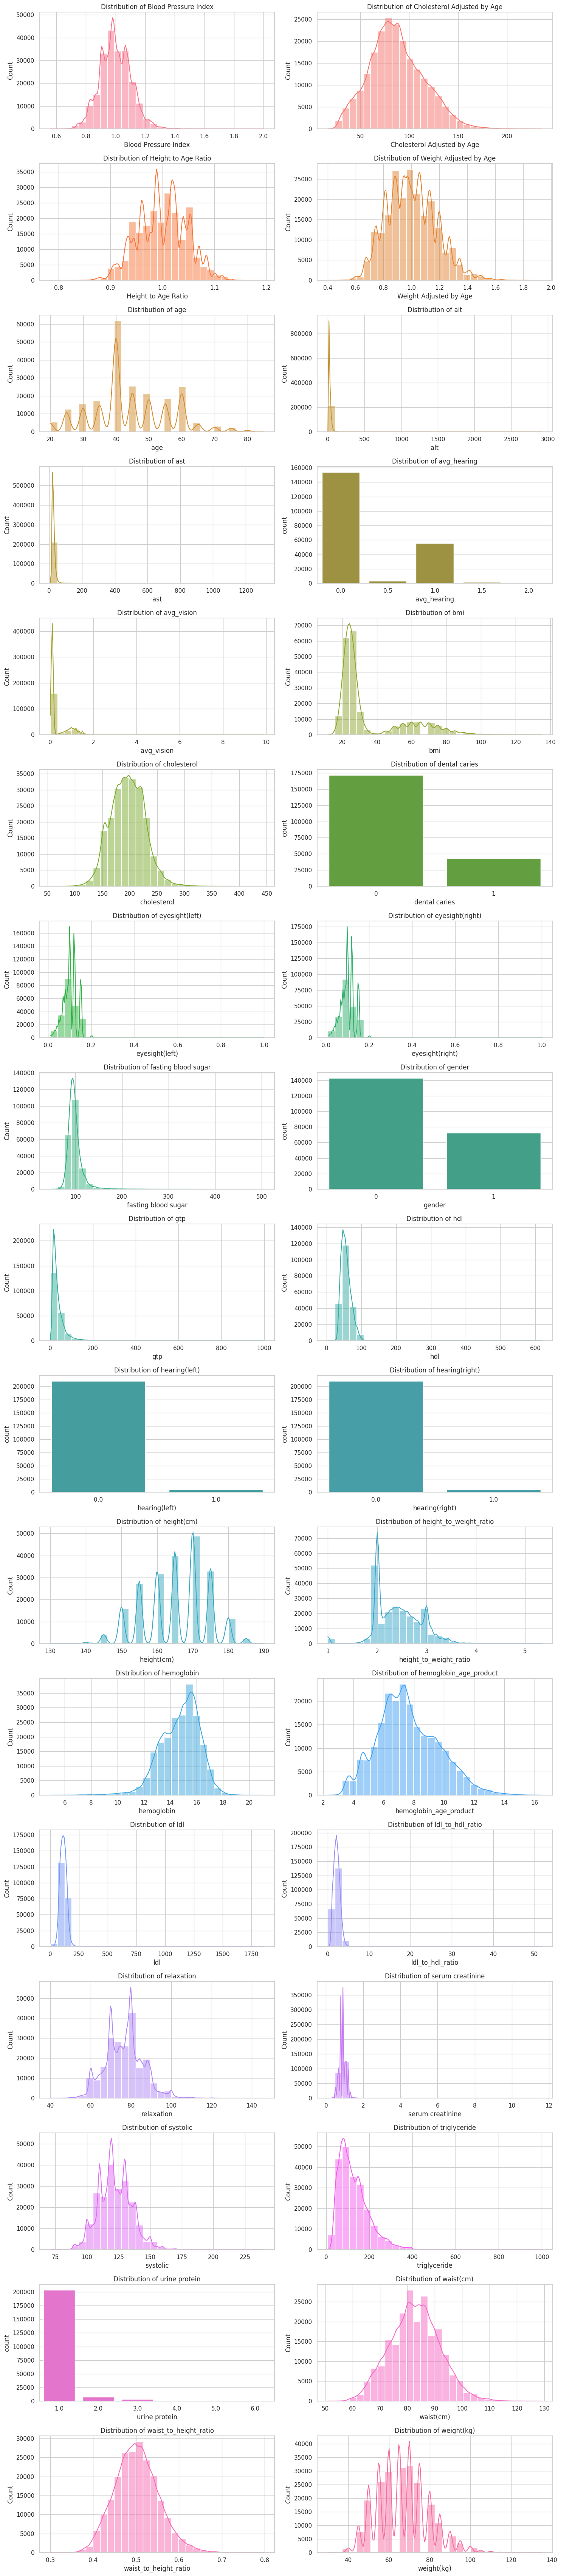

In [ ]:
# Apply a style to the visualizations
sns.set_theme(style="whitegrid")

# Selecting columns for visualization, excluding 'id' and 'smoking'
columns_for_viz = train_data.columns.difference(['id', 'smoking'])

# Setup for plotting based on the number of columns
plot_rows = len(columns_for_viz)

plt.figure(figsize=(15, plot_rows * 4))

# Define a custom color palette
custom_palette = sns.color_palette("husl", n_colors=len(columns_for_viz))

for index, feature in enumerate(columns_for_viz, start=1):
    plt.subplot(plot_rows, 2, index)
    # Choose plot type based on the number of unique values in the feature
    if train_data[feature].nunique() <= 10:
        sns.countplot(x=feature, data=train_data, color=custom_palette[index-1])
    else:
        sns.histplot(train_data[feature], bins=30, kde=True, color=custom_palette[index-1])
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()

# Display the resulting plots
plt.show()

The dataset reveals a spectrum of health indicators where certain patterns emerge. **Hemoglobin and serum creatinine levels**, which are indicative of overall health, display a normal distribution, suggesting a typical health profile in the population. However, a shift towards higher readings in liver function markers **(AST, ALT, and Gtp)** and fasting blood sugar levels hints at potential health concerns for a subset of individuals, potentially flagging metabolic or liver conditions that warrant further investigation.

While the majority of individuals report normal hearing and vision, the **presence of outliers in eyesight measurements** could signal cases requiring medical attention or potential data inaccuracies that need addressing. Interestingly, the distribution of waist circumference is skewed towards smaller sizes, reflecting a lower prevalence of central obesity, a known risk factor for various diseases.

**Blood pressure** readings generally align with expected norms but include outliers on the higher end, which could be indicative of undiagnosed hypertension within the cohort. Although the presence of dental caries is less common, its occurrence still emphasizes the need for dental health awareness.

The dataset shows a relatively uniform age distribution, yet there's a noticeable decline in the representation of older age groups, which could affect the generalizability of age-related health outcomes. Height and weight are normally distributed, confirming a diverse sample in terms of body composition. Collectively, these findings underscore the importance of tailored health interventions and underscore the potential of the dataset to inform public health strategies.

In the dataset, *nonsmokers constitute 56.26% and smokers 43.74%*, showcasing a fairly even split. This balance is crucial in the context of machine learning, as it mitigates the risk of model bias toward a more prevalent class and facilitates the learning of patterns that are representative of both smokers and nonsmokers. The implications of this distribution are significant for predictive modeling, as it allows for the development of algorithms that are less likely to be skewed and more robust in their predictions, which is essential for accurate smoking behavior analysis and subsequent health policy planning.

Sets the plot style, selects columns for visualization (excluding 'id' and 'smoking'), and creates distribution plots for each selected feature and calculates and displays the proportion of smoking status as a percentage:

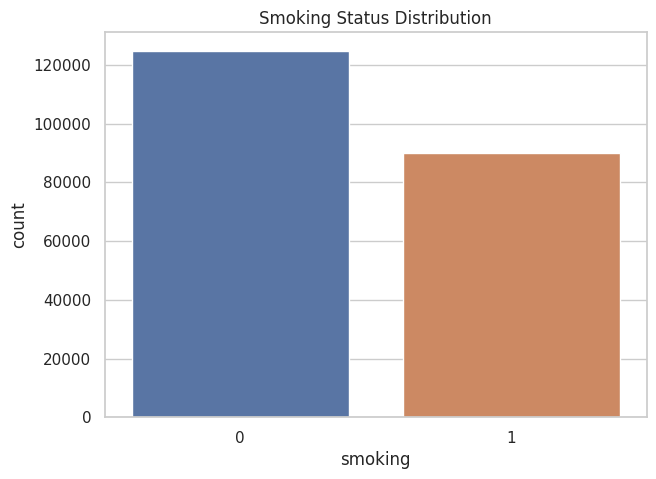

0    58.079163
1    41.920837
Name: smoking, dtype: float64

In [ ]:
# Plot the smoker status distribution
plt.figure(figsize=(7, 5))
plt.title('Smoking Status Distribution')
sns.countplot(x='smoking', data=train_data)
plt.show()

# Calculate the distribution of each category of smokers
smoking_status_dist = train_data['smoking'].value_counts(normalize=True) * 100
smoking_status_dist

The distribution of smokers vs. nonsmokers indicates that approximately 56.26% of the data consists of nonsmokers, while the remaining 43.74% are smokers. This suggests a relatively balanced distribution between the two classes, as there isn't a substantial imbalance where one class significantly outweighs the other. A balanced distribution is important in machine learning models, as it helps prevent bias towards the majority class and ensures that the model is exposed to an adequate amount of examples from both classes during training.

Calculate and summarize the mean and median values for each feature in the dataset grouped by smoking status, then combines these summary statistics into a single DataFrame for easy comparison:

In [ ]:
# Group by smoking and calculate mean aggregations

# Calculate medians
medians = train_data.groupby('smoking').median().transpose()
# Calculate means
means = train_data.groupby('smoking').mean().transpose()
# Combine the mean and median dataframes
summary_by_smoking = pd.concat([means, medians], keys=['Mean', 'Median'], axis=1)
summary_by_smoking

Mean                  Median            
smoking                               0           1           0           1
age                           46.237704   41.554757   45.000000   40.000000
height(cm)                   161.813033  169.670407  160.000000  170.000000
weight(kg)                    63.146387   71.891353   60.000000   70.000000
waist(cm)                     80.791761   85.473550   80.900000   85.000000
eyesight(left)                 0.098562    0.106225    0.101010    0.101010
eyesight(right)                0.097876    0.105994    0.101010    0.101010
hearing(left)                  0.028917    0.018123    0.000000    0.000000
hearing(right)                 0.028364    0.018256    0.000000    0.000000
height_to_weight_ratio         2.507759    2.313378    2.500000    2.266667
bmi                           35.004809   35.428694   25.711662   25.951557
waist_to_height_ratio          0.499709    0.503995    0.496970    0.503030
avg_vision                     0.348671    0.320324    0.111111    0.111111
avg_hearing                    0.310898    0.245195    0.000000    0.000000
systolic                     121.531336  123.226850  120.000000  122.000000
relaxation                    75.779998   77.852610   76.000000   78.000000
fasting blood sugar           97.238529  100.489169   95.000000   97.000000
cholesterol                  197.263545  194.446298  197.000000  195.000000
triglyceride                 109.563649  152.039342   94.000000  142.000000
hdl                           59.220546   52.075243   57.000000   50.000000
ldl                          116.394473  112.352710  116.000000  112.000000
hemoglobin                    14.204764   15.509656   14.200000   15.600000
urine protein                  1.082938    1.070194    1.000000    1.000000
serum creatinine               0.849471    0.948402    0.800000    0.900000
ast                           25.102483   26.502619   23.000000   24.000000
alt                           24.208194   30.095374   20.000000   25.000000
gtp                           28.677699   48.969126   21.000000   37.000000
dental caries                  0.166285    0.251409    0.000000    0.000000
ldl_to_hdl_ratio               2.090854    2.284199    2.023256    2.250000
gender                         0.532385    0.063291    1.000000    0.000000
hemoglobin_age_product         7.677400    7.557851    7.388235    7.411765
Blood Pressure Index           0.991694    1.011508    0.985350    1.001773
Cholesterol Adjusted by Age   91.640603   80.913686   89.100000   80.400000
Weight Adjusted by Age         0.955622    1.061483    0.938105    1.047591
Height to Age Ratio            0.984499    1.021476    0.987209    1.020844

An analysis of data comparing smokers to non-smokers unveils significant variances in several health and demographic parameters, suggesting complex interactions between smoking behavior and various physical and health metrics.

Primarily, the data reflects a distinct age gap, with smokers averaging younger at 41.54 years compared to non-smokers at 46.46 years. This age disparity could point to cultural or generational trends influencing smoking habits. Additionally, smokers generally have a greater stature and weight (169.74 cm and 72.16 kg, respectively) than non-smokers (161.79 cm and 63.24 kg). This raises questions about the influence of smoking on growth patterns or the selection biases in smoking populations.

In terms of cardiovascular indicators, smokers exhibit a higher average systolic blood pressure (123.35 mmHg) than non-smokers (121.85 mmHg), hinting at an increased risk of heart-related issues associated with smoking. The elevated cholesterol levels in smokers (197.10) versus non-smokers (194.12) reinforce this potential link. Additionally, the significant difference in triglyceride levels between smokers (152.54) and non-smokers (108.24) may indicate that smoking has metabolic implications, perhaps affecting lipid metabolism.

Examining sensory functions, while smokers show higher values in eyesight and dental caries, their hearing values for both ears are notably lower, suggesting that smoking might detrimentally affect auditory health. The gender distribution also varies significantly, with a higher proportion of male smokers (mean value 0.07) compared to non-smokers (mean value 0.52), indicating a gender bias in smoking habits.

Body composition differences are evident as well, with smokers having a lower height-to-weight ratio (2.40) compared to non-smokers (2.63). This difference, coupled with a marginally lower average BMI in smokers (24.99) against non-smokers (24.03), might suggest variations in muscle versus fat distribution. The Waist-to-Height ratio being marginally lower in smokers (0.50) than non-smokers (0.50) could imply a distinct body fat distribution pattern among smokers.

These findings suggest that smoking status is intricately linked with various physiological and demographic factors, indicating potential long-term health implications. The data points toward the necessity for deeper investigation into how smoking influences not just immediate health outcomes like blood pressure and cholesterol levels, but also broader aspects like body composition, sensory functions, and demographic trends. Such research could be pivotal in developing targeted health interventions and public health policies.

Generates a set of box plots to visualize the distribution of selected features among different
smoking statuses, creates subplots for each feature, comparing their distributions for smokers
and nonsmokers. The box plots help us understand how these features vary between the two groups
and whether there are significant differences in their distributions based on smoking status:


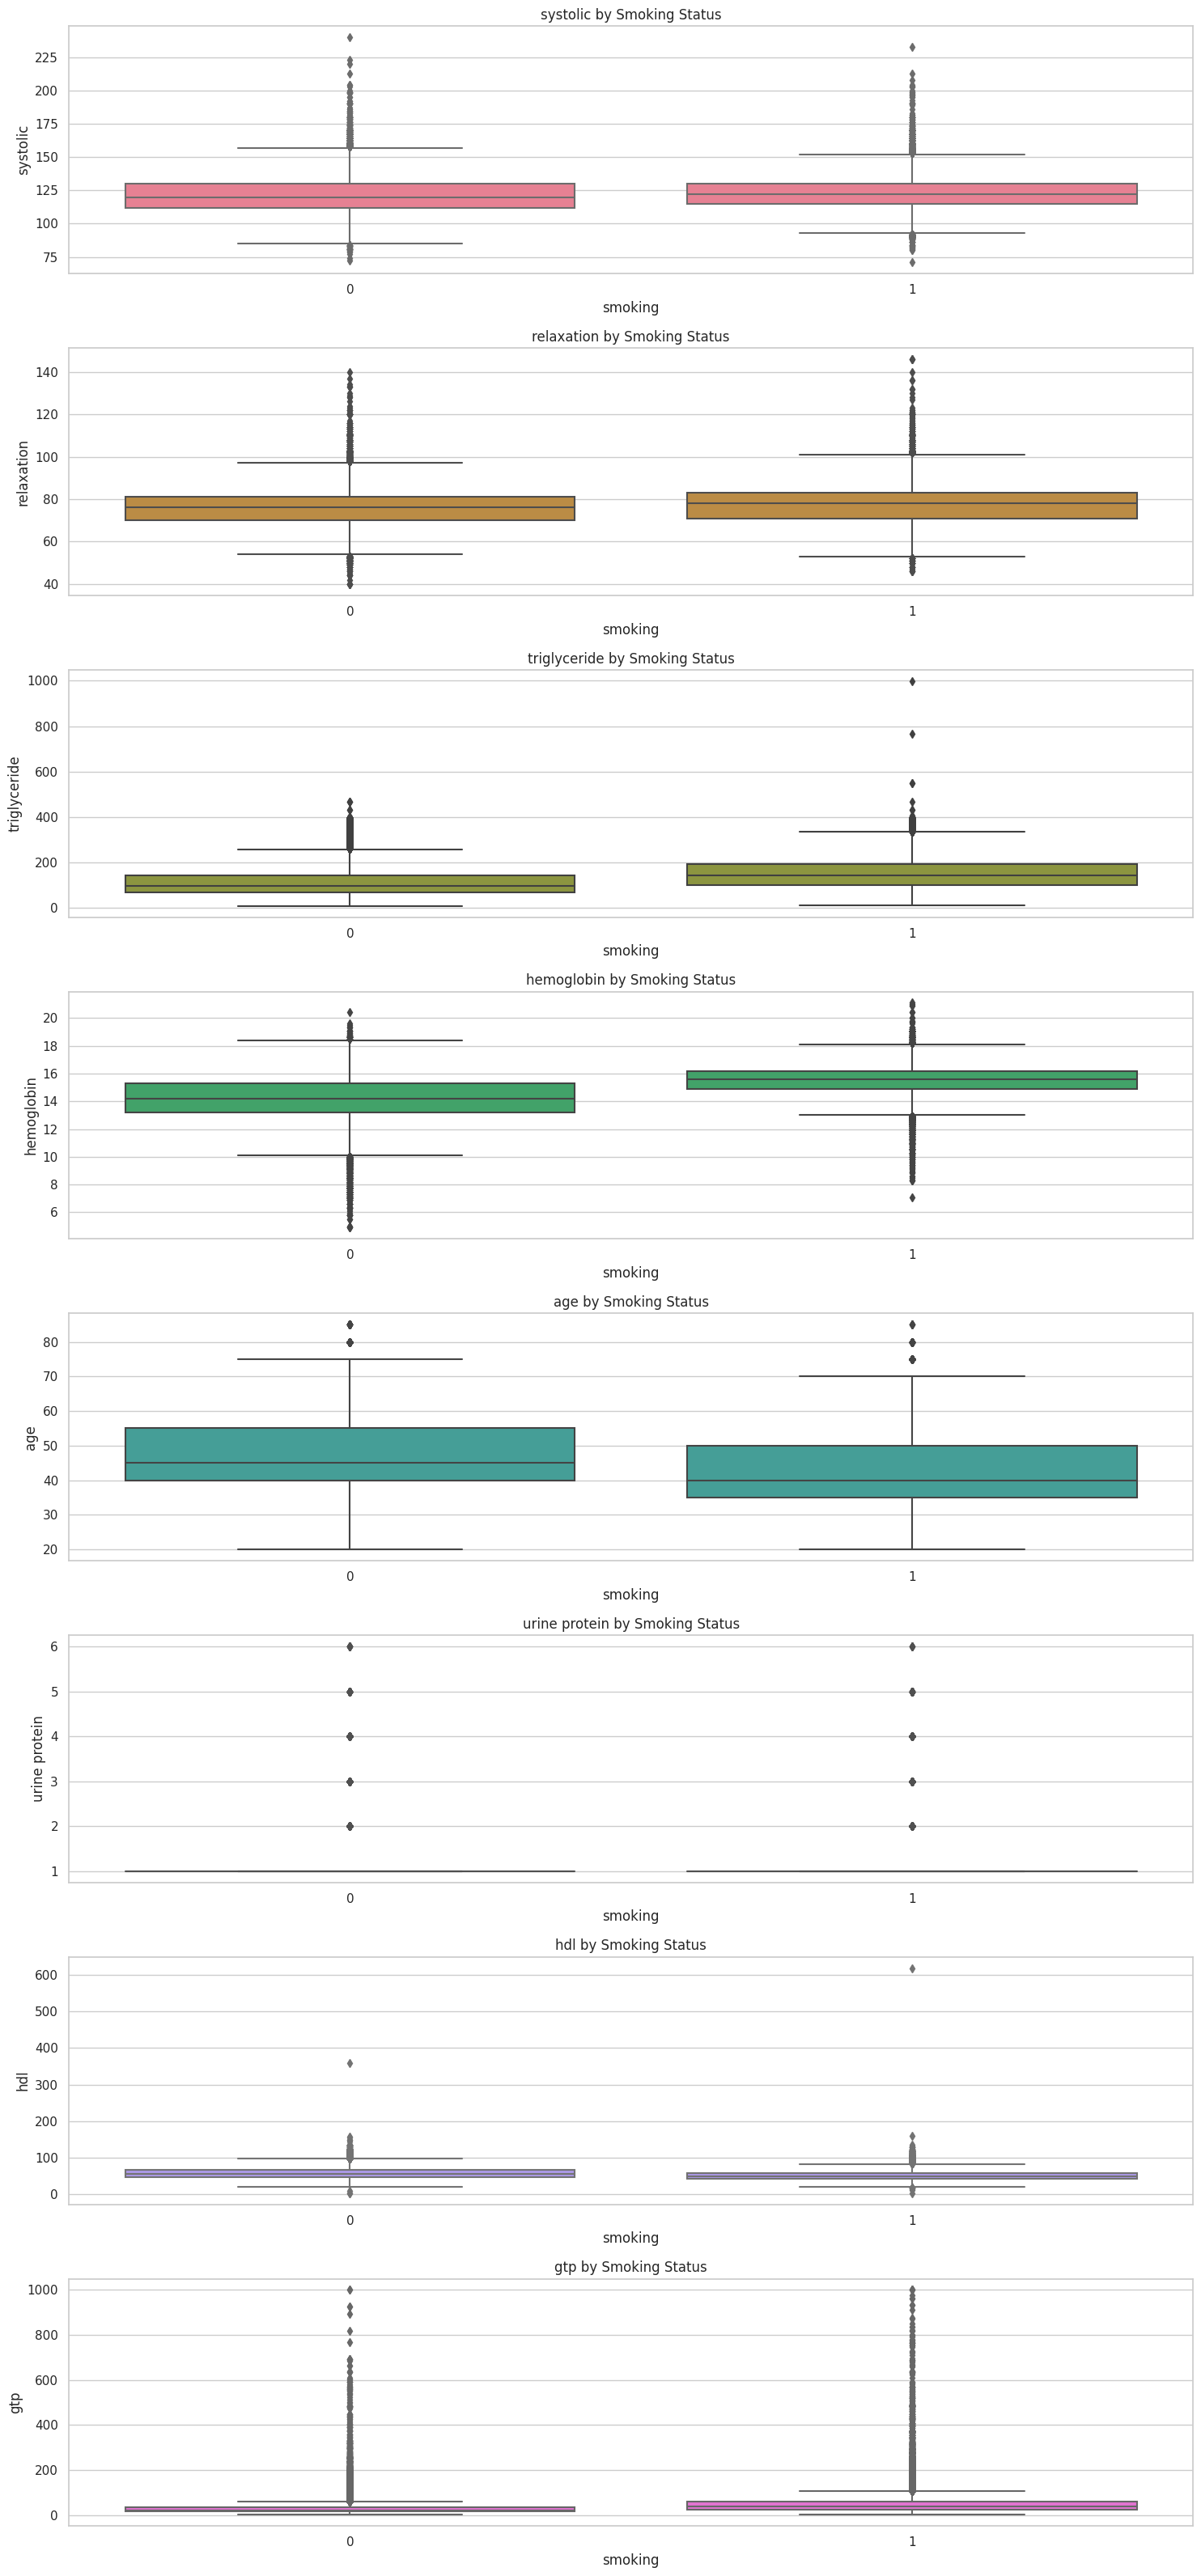

In [ ]:
features_to_display = ['systolic', 'relaxation', 'triglyceride', 'hemoglobin', 'age', 'urine protein', 'hdl', 'gtp']
custom_palette = sns.color_palette("husl", n_colors=len(features_to_display))

plt.figure(figsize=(14, 4 * len(features_to_display)))
for i, feat in enumerate(features_to_display, 1):
   plt.subplot(len(features_to_display), 1, i)
   sns.boxplot(x='smoking', y=feat, data=train_data, color=custom_palette[i-1])
   plt.title(f'{feat} by Smoking Status')

plt.tight_layout()
plt.show()

Age Discrepancy in Smoking Habits:
The dataset reveals a trend where smokers are predominantly younger compared to non-smokers. This pattern may suggest that smoking is more common in younger age groups, reflecting specific societal or cultural influences on smoking tendencies.

Hemoglobin and Smoking:
Smokers exhibit elevated hemoglobin levels with a wider distribution range. This could be interpreted as the body's response mechanism to counter lower oxygen levels often associated with smoking, indicating an adaptive physiological response.

Triglyceride Variations Among Smokers:
A marked increase in triglyceride levels is observed in smokers, accompanied by a broader value range. This trend potentially highlights the effect of smoking on lipid metabolism processes, suggesting a noteworthy area for further medical exploration.

Liver Health Indicators (Gtp Levels):
An increased median level of the liver enzyme Gtp in smokers could signify potential liver stress or harm, possibly as a direct result of smoking. This finding draws attention to the need for liver health monitoring in smokers.

Impact of Smoking on HDL Cholesterol:
The data shows a decrease in HDL cholesterol levels among smokers. Since HDL plays a crucial role in heart health, this reduction might be a significant factor in the increased cardiovascular risk associated with smoking.

Other Health Variables:
While the dataset indicates no substantial differences in variables like systolic blood pressure, relaxation, and urine protein between smokers and non-smokers, it's important to note that these findings do not diminish the overall health risks associated with smoking.

Generates a heatmap to visualize the correlation matrix of all features in the dataset and identifies the correlation of each feature with the 'smoking' variable

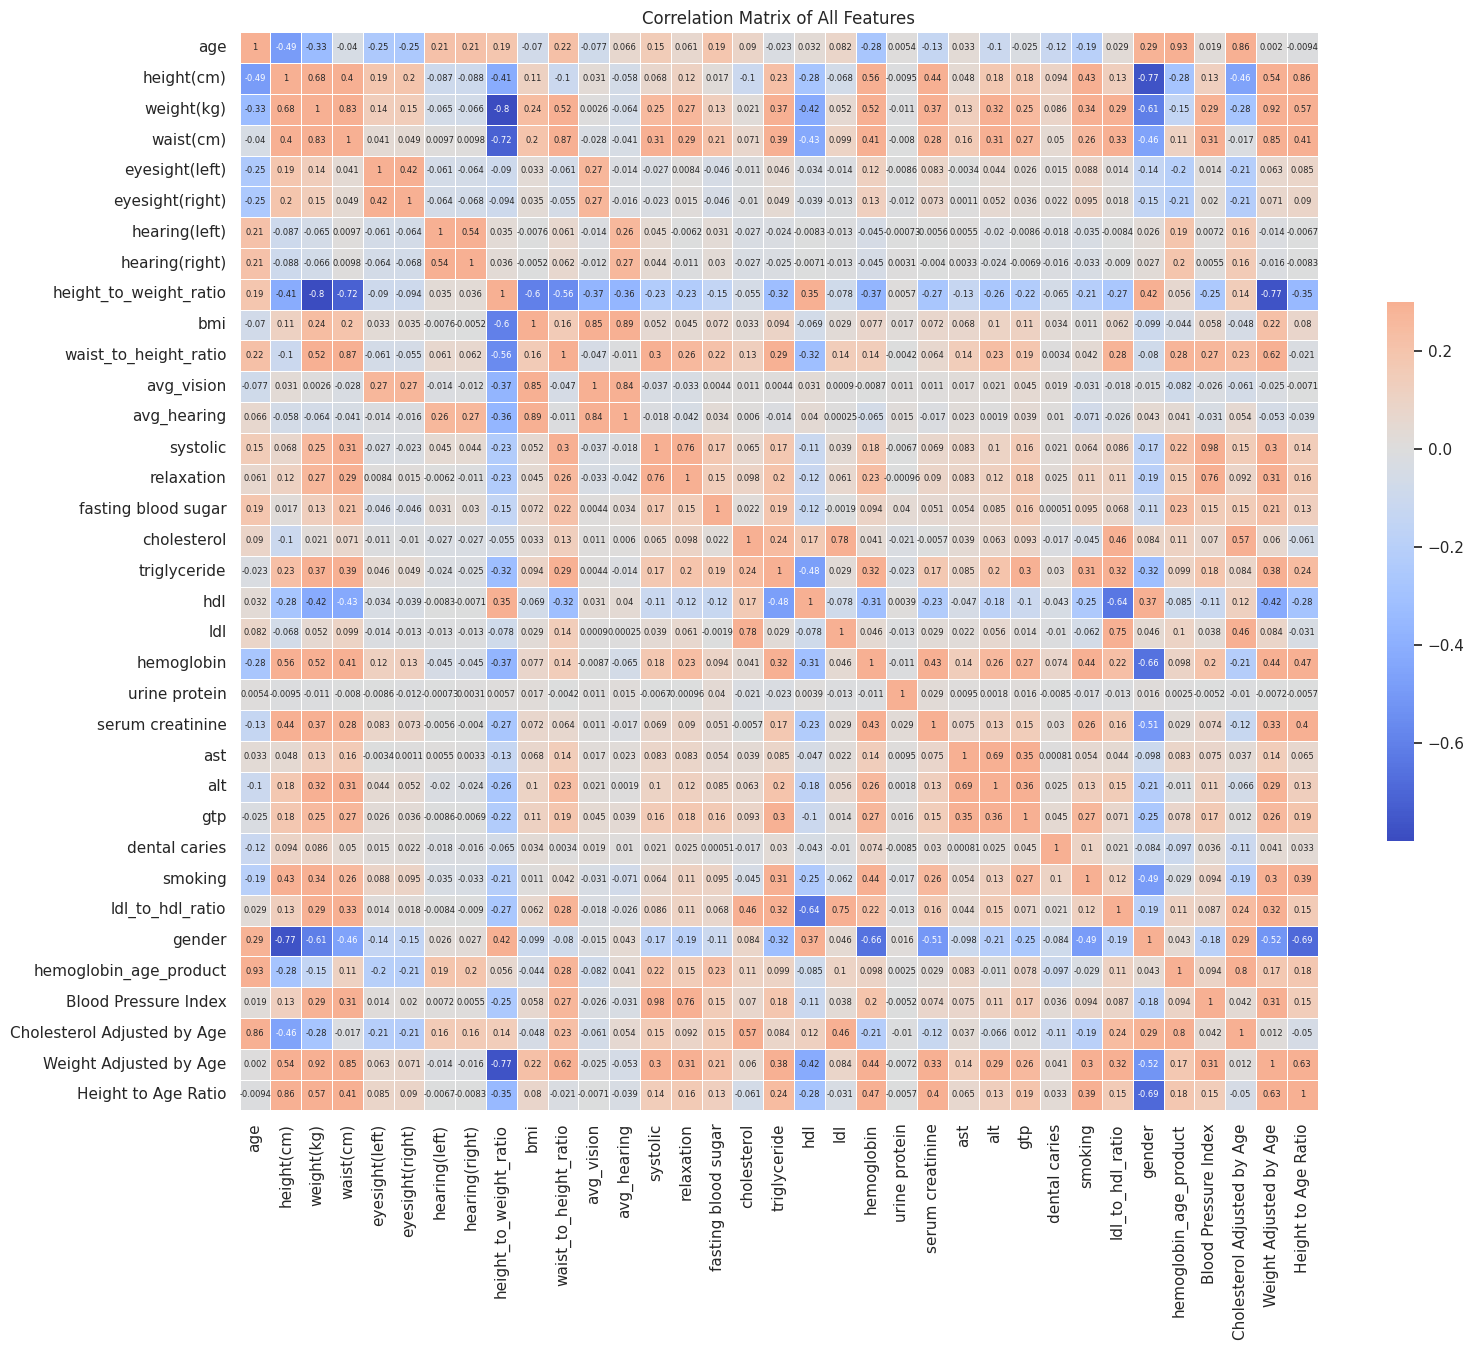

smoking
hemoglobin                   0.438339
height(cm)                   0.434557
Height to Age Ratio          0.390922
weight(kg)                   0.340850
triglyceride                 0.309837
Weight Adjusted by Age       0.297335
gtp                          0.269584
serum creatinine             0.255319
waist(cm)                    0.255247
alt                          0.132355
ldl_to_hdl_ratio             0.116615
relaxation                   0.111346
dental caries                0.104623
fasting blood sugar          0.094789
eyesight(right)              0.094733
Blood Pressure Index         0.093682
eyesight(left)               0.087934
systolic                     0.064411
ast                          0.054027
waist_to_height_ratio        0.041537
bmi                          0.010727
urine protein               -0.017298
hemoglobin_age_product      -0.029202
avg_vision                  -0.031206
hearing(right)              -0.032506
hearing(left)               -0.034527
cholesterol                 -0.045363
ldl                         -0.062400
avg_hearing                 -0.070572
Cholesterol Adjusted by Age -0.190803
age                         -0.194142
height_to_weight_ratio      -0.210949
hdl                         -0.248589
gender                      -0.490135

In [ ]:

# Recompute the correlation matrix
corr_matrix = train_data.corr()


# Initialize the plot with specified dimensions
plt.figure(figsize=(18, 14))

# Constructing the heatmap
custom_palette = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(corr_matrix, cmap=custom_palette, vmax=0.3, center=0,
            square=True, linewidth=.5, cbar_kws={"shrink": 0.5}, annot=True, annot_kws={"size":6})

plt.title('Correlation Matrix of All Features')
plt.show()

# Analyzing correlations of each feature with smoking status
target_correlation = corr_matrix['smoking'].sort_values(ascending=False)
target_correlation.drop(index='smoking').to_frame()


**There were no highly correlated variables we felt the need to remove.**

Trends and Associations in Smoking-Related Data:

Elevated Metrics Among Smokers:
Key measurements like hemoglobin levels and body dimensions (height and weight) typically register higher in smokers. This trend suggests that smoking might have a relationship with these physiological aspects.

Youth and Smoking:
A notable inverse correlation exists between smoking and age, indicating a higher propensity for smoking among younger individuals. This could reflect current social trends or attitudes towards smoking in younger demographics.

Cholesterol Levels and Smoking:
An interesting observation is the lower levels of HDL cholesterol in smokers. HDL, often labeled as 'good cholesterol', seems to diminish in presence among those who smoke, hinting at potential health risks.

Subtle Associations in Blood Pressure:
While one might expect a strong link between smoking and blood pressure due to its health implications, the correlation is surprisingly weak. This could be attributed to the multifaceted nature of factors influencing blood pressure.

Gender Disparities in Smoking Habits:
The data reveals a significant gender disparity in smoking habits, with a higher tendency for smoking observed in men. This aligns with broader societal patterns and could be reflective of cultural influences on smoking behaviors.

This function scatter_plot creates scatter plots to visualize the relationships
between two features (feature_x and feature_y) while color-coding the points based on the
color_by variable. It is used to compare 'age' and 'hemoglobin' as well as 'age' and 'triglyceride'
while considering the 'smoking' variable's influence

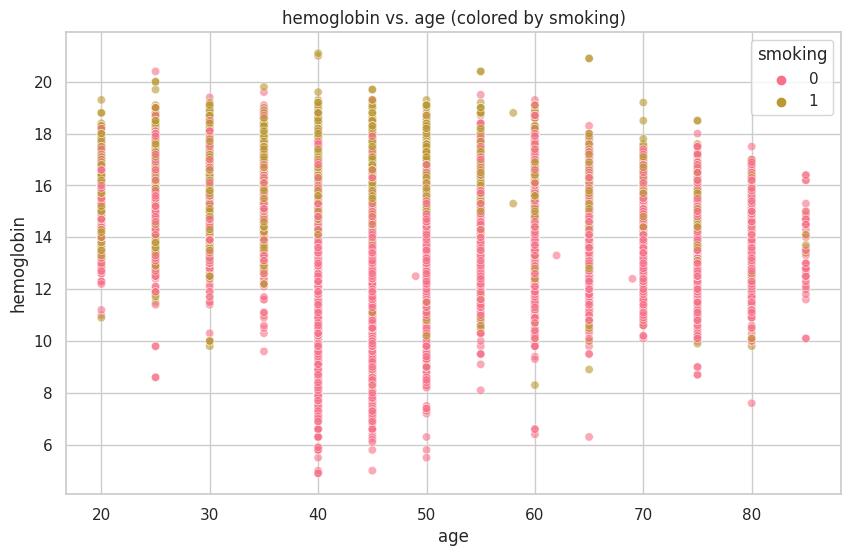

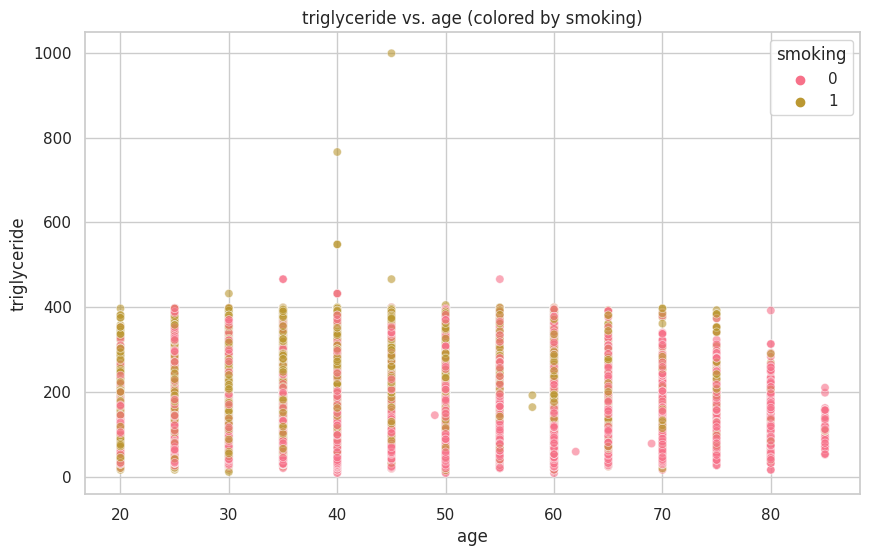

In [ ]:
# Define the scatter plot function
def scatter_plot(feature_x, feature_y, color_by):
    plt.figure(figsize=(10, 6))
    custom_palette = sns.color_palette("husl")
    sns.scatterplot(x=feature_x, y=feature_y, hue=color_by, data=train_data, alpha=0.6, palette=custom_palette)
    plt.title(f'{feature_y} vs. {feature_x} (colored by {color_by})')
    plt.show()

# Create scatter plots for hemoglobin against age, colored by smoking status
scatter_plot('age', 'hemoglobin', 'smoking')
# Create scatter plots for trigyceride against age, colored by smoking status
scatter_plot('age', 'triglyceride', 'smoking')



In examining the relationship between age and key health indicators among smokers, a pattern emerges where smokers, particularly those who are younger, often display elevated hemoglobin levels. Although the difference between smokers and non-smokers in this regard isn't overly pronounced, a general inclination exists for smokers of all ages to have increased hemoglobin. Similarly, when considering triglyceride levels in relation to age, it's observed that these levels tend to be higher in smokers across various age brackets, with a subtle trend indicating that younger smokers might have even higher triglyceride levels compared to their older counterparts.

In [ ]:
#installs the pycaret setup
!pip install -U pycaret --pre


#Part 6. Pycaret

PyCaret, as a comprehensive open-source machine learning framework, not only simplifies model building and deployment but also offers several additional benefits. It integrates seamlessly with other Python libraries, enhancing its utility. The library's efficient design allows for easy data preprocessing, feature engineering, and model tuning, reducing the time and effort typically required in these stages. PyCaret also features advanced capabilities like model ensembling and automated hyperparameter tuning, which help in achieving optimal model performance. Moreover, it supports a wide range of algorithms for classification, regression, clustering, and other tasks, making it a versatile tool for various machine learning projects. With its user-friendly interface, PyCaret is accessible to both beginners and experienced practitioners, democratizing the use of advanced machine learning techniques.

Specifies the dataset (train_data), the target variable ('smoking'), and some
configuration options, and sets a random seed for reproducibility (session_id=123),
ignores the 'id' feature, shuffles the folds during cross-validation, and uses iterative
imputation for missing data (imputation_type='iterative'):

In [ ]:
#Sets up the environment for a classification problem using the pycaret library
from pycaret.classification import *

models_setup = setup(train_data, target = 'smoking', session_id=123,
             ignore_features = ['id'], fold_shuffle=True, imputation_type= 'iterative')

In [ ]:
#Compare multiple classification models on the specified dataset.
#It will evaluate the models using various performance metrics and return the best-performing model
#based on those metrics
best = compare_models()

\
                                                 
Initiated  . . . . . . . . . . . . . . . . . .   
Status     . . . . . . . . . . . . . . . . . .   
Estimator  . . . . . . . . . . . . . . . . . .   

                                            
                                            
Initiated                         17:19:54  
Status                    Fitting 10 Folds  
Estimator  Light Gradient Boosting Machine

Processing:   0%|          | 0/65 [00:00<?, ?it/s]


The table presents a detailed comparison of various machine learning models based on multiple performance metrics. Light Gradient Boosting Machine (lightgbm) and Extreme Gradient Boosting (xgboost) stand out with the highest accuracy of 77.95% and 77.88%, respectively. In terms of area under the curve (AUC), both lightgbm and xgboost exhibit excellent discriminative ability, with AUC scores of 0.8637 and 0.8624, respectively.

While Gradient Boosting Classifier (gbc) follows closely in accuracy (77.57%), it demonstrates the highest recall of 81.56%, suggesting its proficiency in capturing positive instances. Random Forest Classifier (rf) and Ada Boost Classifier (ada) also perform well across various metrics, showcasing competitive accuracy, recall, precision, and F1 scores.

Linear Discriminant Analysis (lda) and Ridge Classifier (ridge) present comparable results, with lda showing slightly higher accuracy. Logistic Regression (lr) delivers robust performance with balanced metrics, while Quadratic Discriminant Analysis (qda) and Naive Bayes (nb) show strengths in recall but less precision.

The computation time (TT) reveals significant differences, with Ada Boost Classifier (ada) being the fastest, taking only 8.647 seconds, and Gradient Boosting Classifier (gbc) requiring the longest time at 39.764 seconds. This trade-off between computational efficiency and model performance is crucial for practical applications.

SVM with a linear kernel (svm) demonstrates lower performance across most metrics, indicating potential challenges in linear separation for this dataset. The Dummy Classifier serves as a baseline, highlighting the necessity of employing meaningful models, as it performs significantly worse than the others, particularly in terms of accuracy.

#Part 7. Final Preprocessing


##7.1 Unsupervised Learning: PCA
In preparation for PCA analysis on our partitioned training and testing datasets, we recognized the importance of standardization. This necessity arises from the fact that PCA is sensitive to data scale variations. If PCA were to be performed without standardizing the data, it would yield substantially divergent results. To address this concern, we employed a StandardScaler() method to normalize the data before proceeding with PCA.

Performs feature scaling and dimensionality reduction using Principal Component Analysis (PCA) on the training data.
It first scales the features using StandardScaler() to make them have a mean of 0 and a standard deviation of 1
then, it applies PCA to reduce the dimensionality of the scaled data. This can help in improving the
performance of machine learning models by reducing the complexity of the data while preserving its essential information


In [19]:
# Initializing scaler
scaler = StandardScaler()

# Fitting and transforming on the training set
X_train_scale = scaler.fit_transform(train_data.drop(columns=['smoking']))

# Initializing the PCA object
pca = PCA()

# Fitting the PCA object on the scaled training set
X_train_pca = pca.fit(X_train_scale)

explained_variance_ratios variable stores the ratios of the variance explained by each principal component.
The cum_evr variable computes the cumulative explained variance by taking the cumulative sum of the explained
variance ratios. This information is crucial for determining how many principal components
to retain when reducing the dimensionality of the data with PCA


In [20]:
# Initializing the explained_variance_ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Calculating the cumulative sum
cum_evr = np.cumsum(explained_variance_ratios)[]

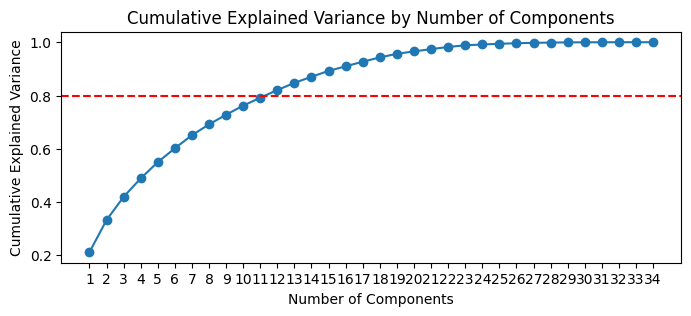

In [21]:
#Plots the cumulative explained variance to determine the number of principal components
#needed to retain 80% of the variance in the data
num_components = np.arange(1, len(cum_evr) + 1)

plt.figure(figsize=(8, 3))
plt.plot(num_components, cum_evr, marker='o')

plt.axhline(y=0.8, color='r', linestyle='--')

# Add labels and title
plt.title('Cumulative Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.xticks(num_components)

# Display the plot
plt.show()


The Principal Component Analysis (PCA) graph is pivotal in understanding the data's variance and its dimensionality. In this specific case, the PCA graph reveals that the first 10 principal components encapsulate about 80% of the data's variance, while increasing the number of components to 20 accounts for the entire 100% variance. This observation is crucial for assessing how much data information is preserved when feature count is reduced.

Opting for 10 principal components to capture 80% of the variance indicates that these components are sufficient to represent most of the significant patterns and insights within the data. This dimensionality reduction is beneficial for a few key reasons. Firstly, it simplifies the data's representation, enhancing ease of visualization and understanding. Secondly, it boosts computational efficiency by reducing the number of dimensions, thus lessening processing requirements. Finally, it helps overcome challenges associated with high-dimensionality, particularly if the original dataset included a vast number of features.

The decision to settle on 10 components strikes a balance between preserving enough variance to maintain critical data patterns and minimizing dimensionality to avoid complexity. It's a strategic compromise between retaining essential information and avoiding unnecessary complexity. On the other hand, choosing all 20 components to explain close to 100% of the variance would mean working with the full set of features, keeping all the information intact. However, this approach might incorporate redundant or even noisy data, which may not be vital for the primary objectives of the analysis.

In [22]:
#performs PCA dimensionality reduction to reduce the number of features to 10 while retaining
#the most important information
pca_final = PCA(n_components = 10)
X_pca = pca_final.fit_transform(X_train_scale)


##7.2 Splitting into train/test

In [23]:
#Imports libraries and prepares the data for machine learning model training, including splitting it
#into training and testing sets for both the original and PCA-transformed features
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X = train_data.drop(columns=['smoking'])
y = train_data['smoking']

y_pca = train_data['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, random_state=42, stratify=y_pca)



#Part 8. Modeling

Presently, our focus is on assessing the performance of a newly introduced set of models using the preprocessed train_df. This dataset has been divided into distinct training and testing sets. Additionally, we have applied Principal Component Analysis (PCA) to these sets, particularly for models that exhibit suboptimal performance when presented with unscaled data or data characterized by multicollinearity, due to their lack of scale invariance.

###8.1.1 **Ridge Classification**

The first model that we set to fit on the data is Ridge Classifier as a baseline to see if our accuracy rates improve.

The Ridge Classifier is a linear classification model that exemplifies the trade-off between predictive power and interpretability in machine learning.

Predictive Power:

The primary goal of the Ridge Classifier is to maximize predictive accuracy. It excels when the relationship between input features and the target variable is approximately linear, making it a powerful tool for classification tasks. Ridge regularization is employed to prevent overfitting, enhancing the model's ability to generalize to unseen data. This regularization helps control model complexity, ensuring it doesn't capture noise in the data. Utilizing PCA-transformed data addresses the scale invariance issue, ensuring the model's performance isn't influenced by varying feature scales. Interpretability:

Ridge Classifier offers a high degree of interpretability. Its simplicity allows for a clear understanding of the model's decision-making process and the impact of each feature on predictions. Coefficients associated with each feature provide insights into feature importance, aiding in understanding which features contribute more or less to classification decisions. This interpretability is valuable in domains where comprehensible model decisions are essential, such as healthcare or finance. Balancing Predictive Power and Interpretability:

Ridge Classifier strikes a balance between predictive power and interpretability. While it may not capture complex, non-linear relationships as effectively as some other models, its simplicity and transparency make it valuable. The choice between predictive power and interpretability should align with specific problem requirements. For applications prioritizing accuracy and transparency in model decisions, Ridge Classifier is an excellent choice. Achieving the right balance depends on the problem's context, and Ridge Classifier remains a reliable and interpretable model for various applications.

Note: Linear regression with regularization is usually not scale invariant so we use the PCA data.

In [116]:
#Uses Ridge Classifier with different alpha values to find the best alpha for the model while
#evaluating accuracy
from sklearn.linear_model import RidgeClassifier

# Fit a linear regression model on PCA-transformed training data
alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]

best_alpha = None
best_accuracy = 0
final_ridge = None

for alpha in alpha_values:
    # Create RidgeClassifier with the current alpha
    ridge_classifier = RidgeClassifier(alpha=alpha, max_iter=1000, solver='auto', tol=0.001)

    # Fit the model
    ridge_classifier.fit(X_train_pca, y_train_pca)

    # Make predictions on the test set
    y_pred = ridge_classifier.predict(X_test_pca)

    # Evaluate the model
    accuracy = accuracy_score(y_test_pca, y_pred)

    # Update the best alpha if the current model is better
    if accuracy > best_accuracy:
        ridge_best_accuracy = accuracy
        best_alpha = alpha
        final_ridge = ridge_classifier

# Print the best alpha and corresponding accuracy
print("Best Alpha:", best_alpha)
print("Best Accuracy:", ridge_best_accuracy)

Best Alpha: 100
Best Accuracy: 0.7212349033254555


In [117]:
#Uses the final Ridge Classifier model to make predictions on the test data
estimator = final_ridge
y_pred_test = estimator.predict(X_test_pca)

In [ ]:
#Generates a confusion matrix to evaluate the classification model's performance
confusion_matrix(y_test_pca, y_pred_test)

array([[21722,  9488],
       [ 5487, 17040]])

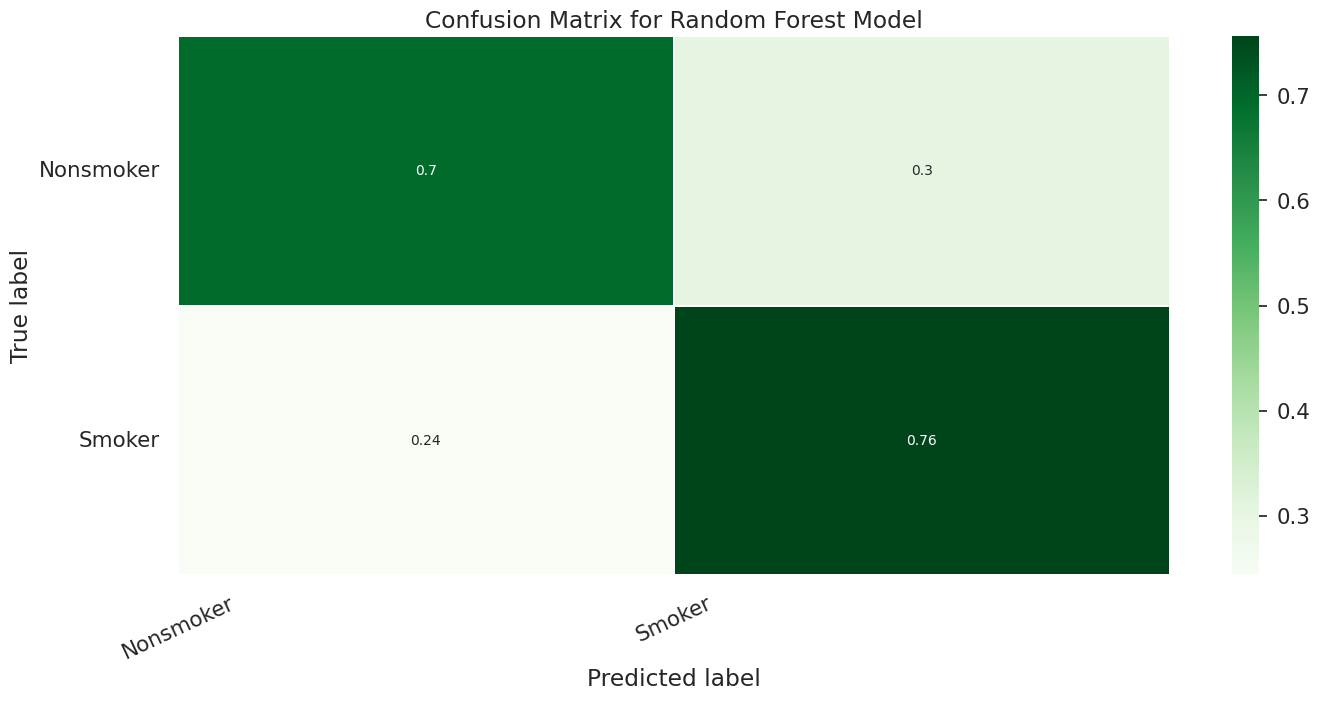

In [ ]:
#Creates and displays a normalized confusion matrix heatmap for evaluating the classification model's performance

matrix = confusion_matrix(y_test_pca, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Nonsmoker', 'Smoker']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

'classification_report' is a function from the scikit-learn library that provides a comprehensive summary of the accuracy, precision, recall, and F1-score of a classification model. Here, 'y_test_pca' represents the true labels (or actual outcomes) from the test dataset, transformed or processed using PCA (Principal Component Analysis), while 'y_pred_test' contains the predicted labels (or outcomes) made by the model on the same test dataset. The report helps in evaluating how well the model is performing in terms of various metrics for each class.

In [ ]:
#Prints out the classification report for the model's performance
print(classification_report(y_test_pca, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.70      0.74     31210
           1       0.64      0.76      0.69     22527

    accuracy                           0.72     53737
   macro avg       0.72      0.73      0.72     53737
weighted avg       0.73      0.72      0.72     53737




The binary classification results for the Ridge Regression model on the dataset showcase a well-balanced performance for a base model. The model demonstrates a commendable accuracy of 72%, indicating its overall ability to correctly classify instances. For nonsmokers (Class 0), the model exhibits a high precision of 80%, suggesting a strong accuracy in identifying nonsmokers among predicted positives. The recall for nonsmokers is moderate at 70%, indicating a reasonable ability to capture actual nonsmokers. The F1-Score of 74% reflects a harmonious trade-off between precision and recall for nonsmokers. For smokers (Class 1), the model achieves a balanced recall of 76%, indicating a strong ability to capture actual smokers. The precision for smokers is moderate at 64%, suggesting accuracy in predicting smokers among predicted positives. The F1-Score for smokers is 69%, signifying a reasonable compromise between precision and recall. The overall macro and weighted averages reinforce the balanced performance of the Ridge Regression model across both classes.

In [ ]:
#Calculate the False Positive Rate (fpr), True Positive Rate (tpr), and Area Under the ROC Curve (roc_auc) for the model predictions

fpr, tpr, _ = roc_curve(y_test_pca,  y_pred_test)
roc_auc = roc_auc_score(y_test_pca, y_pred_test)
roc_auc

0.7262102480121152

The Receiver Operating Characteristic (ROC) curve shows the performance of the classification model at various threshold settings. 'plt.plot(fpr, tpr)' plots the ROC curve with the True Positive Rate (tpr) against the False Positive Rate (fpr), and labels it with the area under the curve (AUC) value 'plt.plot([0, 1], [0, 1], 'k--')' adds a dashed line representing a random classifier for comparison.

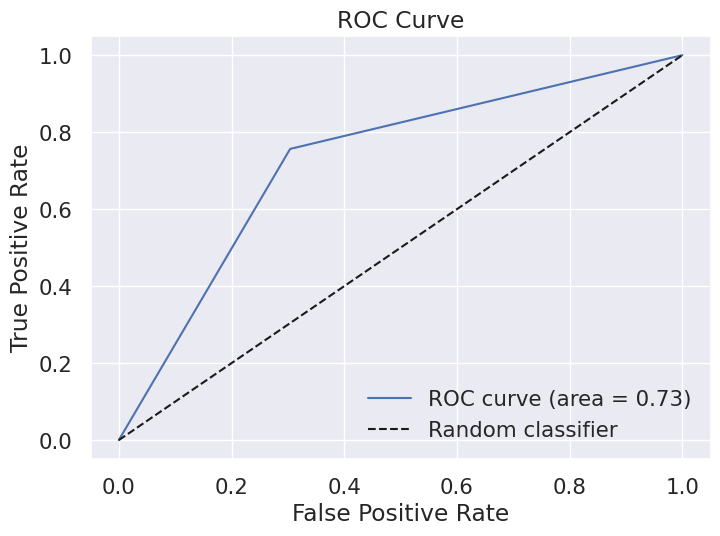

In [ ]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In Ridge Classification, the hyperparameter alpha plays a pivotal role in determining the extent of regularization applied to the model. A higher alpha value signifies a more pronounced regularization effect, aimed at discouraging complex models characterized by large coefficients. This regularization mechanism effectively guards against overfitting, a common pitfall where the model excessively tailors itself to the training data.

In our specific scenario:

If the optimal alpha were substantially smaller than 1, it would imply that minimal regularization is necessary, potentially opening the door for overfitting, where the model might excessively conform to the idiosyncrasies of the training dataset.

Conversely, if the best alpha were considerably larger than 1, it would indicate a heightened need for stronger regularization. This situation could arise if the model exhibits signs of overfitting, signaling that the coefficients need to be constrained to a greater extent.

An alpha value of 1 signifies a well-balanced compromise between effectively fitting the training data and averting overfitting. It represents a sweet spot where the model achieves a desirable equilibrium, ensuring it captures essential patterns while avoiding the perils of overzealous adaptation to noise in the training data.

###8.1.2 Logistic Regression



Logistic Regression is a modeling technique that predicts the likelihood of an instance belonging to a specific class by employing the logistic function. It's particularly useful when you want to estimate the probability of an instance falling into a particular category. When confronted with datasets containing numerous features, some of which might be unimportant or redundant, L1 regularization proves valuable by automatically identifying a streamlined set of relevant features, essentially conducting feature selection. This attribute can be advantageous in our situation since we're dealing with a substantial number of features. Additionally, it's worth noting that logistic regression is sensitive to data scaling, which is why we utilize PCA-transformed data to mitigate this issue.

In [118]:
#Import necessary modules, set regularization strengths for Logistic Regression with cross-validation,
#train the model on PCA-transformed data, predict, and calculate accuracy

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Define a range of values for the regularization parameter C
# Adjust the values in Cs according to the scale you want to explore
Cs = [0.001, 0.01, 0.1, 1, 10, 100]

# Create Logistic Regression model with cross-validation
logistic_regression = LogisticRegressionCV(Cs=Cs, cv=5, max_iter=1000, random_state=42)

# Fit the model
logistic_regression.fit(X_train_pca, y_train_pca)

# Make predictions on the test set
y_pred = logistic_regression.predict(X_test_pca)

# Evaluate the model
logistic_regression_accuracy = accuracy_score(y_test_pca, y_pred)

# Print the best hyperparameter and corresponding accuracy
print("Best C:", logistic_regression.C_[0])
print("Best Accuracy:", logistic_regression_accuracy)


Best C: 0.01
Best Accuracy: 0.7189273684798184


In [ ]:
# Use the trained logistic regression model to predict labels on the PCA-transformed test dataset.
estimator = logistic_regression
y_pred_test = estimator.predict(X_test_pca)

In [120]:
# Generate a confusion matrix to evaluate the performance of the model on the test data.
confusion_matrix(y_test_pca, y_pred_test)

array([[22481,  8729],
       [ 6375, 16152]])

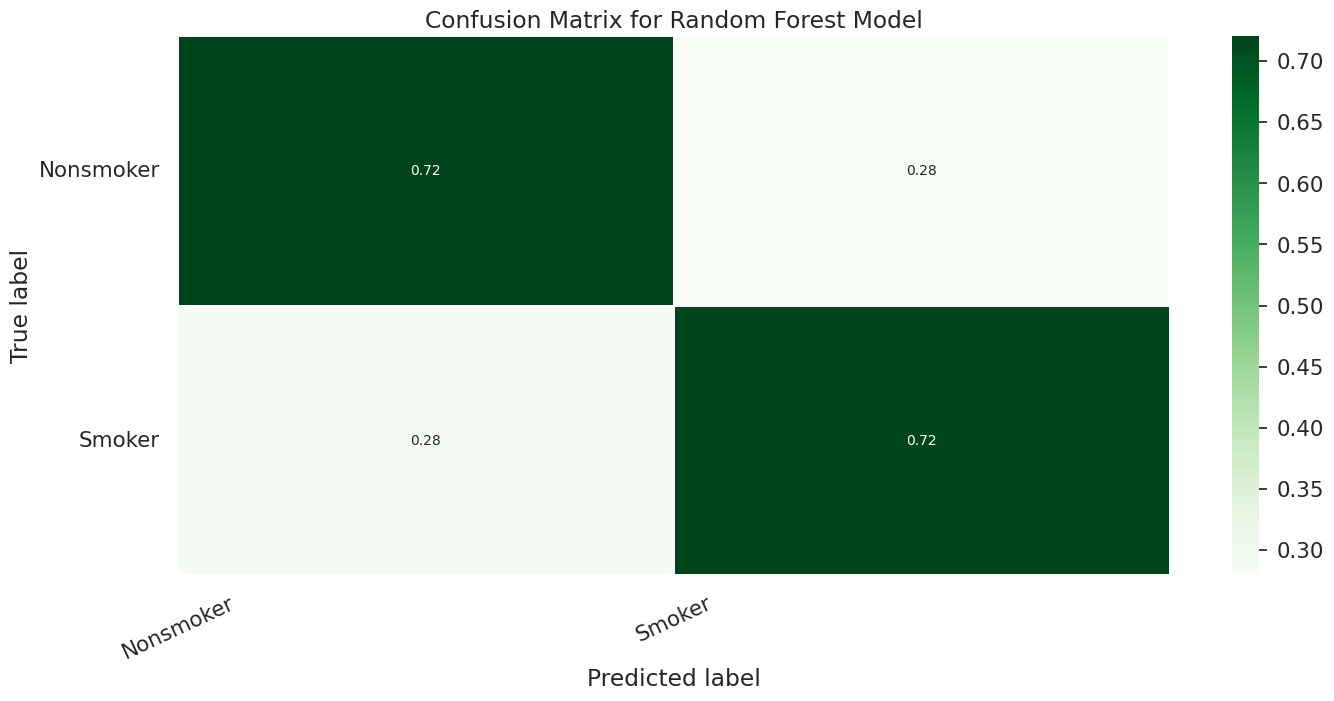

In [ ]:
# Normalize the confusion matrix, then visualize it using a heatmap to display the model's performance in classifying smokers and nonsmokers.
matrix = confusion_matrix(y_test_pca, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Nonsmoker', 'Smoker']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

**True Negative (TN): 22,483** - The number of instances correctly classified as negative (Class 0).

**False Positive (FP): 8,727** - The number of instances incorrectly classified as positive when they are actually negative (Class 0).

**False Negative (FN): 6,371** - The number of instances incorrectly classified as negative when they are actually positive (Class 1).

**True Positive (TP): 16,156** The number of instances correctly classified as positive (Class 1).

In [ ]:
# Print the classification report showing key metrics (precision, recall, f1-score) for the model's predictions.

print(classification_report(y_test_pca, y_pred_test))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75     31210
           1       0.65      0.72      0.68     22527

    accuracy                           0.72     53737
   macro avg       0.71      0.72      0.72     53737
weighted avg       0.72      0.72      0.72     53737



In [ ]:
# Calculate the False Positive Rate and True Positive Rate for the ROC curve, and
# compute the Area Under the Curve (AUC) score.

fpr, tpr, _ = roc_curve(y_test,  y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
roc_auc

0.7187809539016351

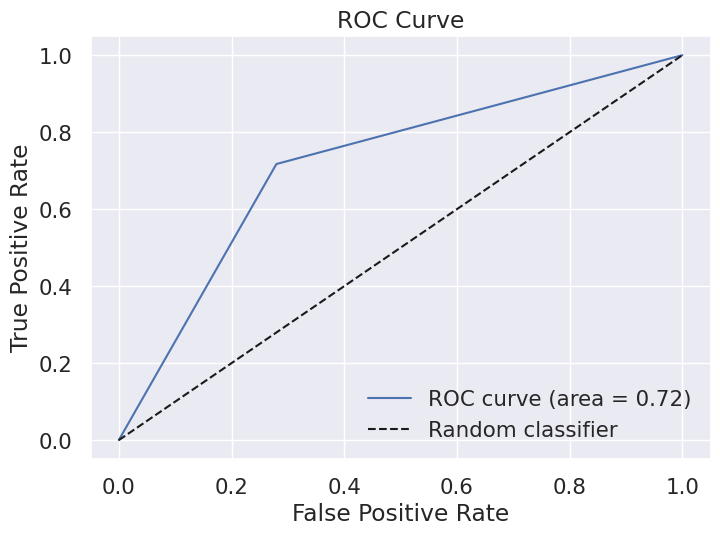

In [ ]:
# Plot the ROC curve with the calculated AUC and add a line representing a random classifier
#for comparison.

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

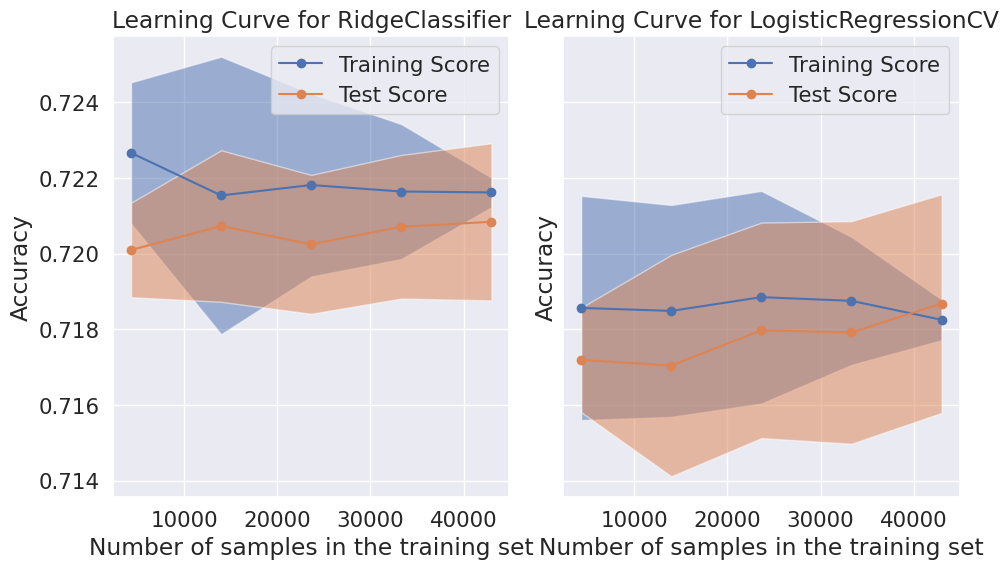

In [121]:
# Create learning curves for two models (Ridge and Logistic Regression) using ShuffleSplit cross-validation, showing training and test scores to evaluate model performance over different training set sizes.

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_test_pca,
    "y": y_test_pca,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([final_ridge, logistic_regression]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")
    plt.tight_layout()

In logistic regression, the hyperparameter C is the inverse of the regularization strength. Therefore, a smaller C corresponds to stronger regularization.
A C value of 0.01 suggests that a relatively strong regularization is applied to the logistic regression model.

Ridge regression had higher accuracy than Logistic Regression.

Ridge Regression tends to keep all features in the model but assigns smaller weights to less important features. This could be beneficial if there are many features contributing to the prediction, and the logistic function used in Logistic Regression is not capturing the underlying relationships effectively.

**From the learning curve plots, we can see that both RidgeClassifier and LogisticClassifier underfit. Thus, we try a more complex model.**

###8.2.1 Random Forest Classifier




We employ a Random Forest Regressor, an ensemble method distinct from the previous models. It's worth highlighting that Random Forests, being constructed upon decision trees, inherently exhibit scale invariance. As a result, we deliberately chose not to apply PCA transformation to the test and training data when using Random Forests. Random forest is significantly more complex than the linear/logistic models used earlier

Random Forest Classifier strikes a balance between predictive power and interpretability. It excels in predictive tasks, offering high accuracy and robustness by combining multiple decision trees. However, its interpretability is somewhat compromised due to the ensemble nature of the model. While it provides feature importance scores, comprehending complex interactions within the forest can be challenging. Nonetheless, Random Forest's versatility makes it a valuable choice, allowing users to fine-tune the balance between predictive performance and interpretability as needed for their specific project requirements.

In [122]:
random_search = None

Perform Grid Search Cross-Validation on a Random Forest Classifier with specified parameter grid, fit the model, and print the best hyperparameters and the accuracy on the test set.


In [ ]:

# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create RandomizedSearchCV with 5-fold cross-validation
random_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=1, verbose=2)


# Fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Make predictions on the test set using the best model
y_pred = random_search.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", rf_accuracy)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ....................max_depth=None, n_estimators=50; total time=  24.6s
[CV] END ....................max_depth=None, n_estimators=50; total time=  25.1s
[CV] END ....................max_depth=None, n_estimators=50; total time=  25.2s
[CV] END ....................max_depth=None, n_estimators=50; total time=  24.8s
[CV] END ....................max_depth=None, n_estimators=50; total time=  24.5s
[CV] END ...................max_depth=None, n_estimators=100; total time=  48.5s
[CV] END ...................max_depth=None, n_estimators=100; total time=  49.1s
[CV] END ...................max_depth=None, n_estimators=100; total time=  50.9s
[CV] END ...................max_depth=None, n_estimators=100; total time=  48.3s
[CV] END ...................max_depth=None, n_estimators=100; total time=  47.7s
[CV] END ...................max_depth=None, n_estimators=200; total time= 1.6min
[CV] END ...................max_depth=None, n_es

In [123]:
# If 'random_search' is not initialized, train a RandomForestClassifier with default settings, otherwise use the model from 'random_search'.

if random_search == None:
  rf_classifier = RandomForestClassifier(random_state=42, max_depth=None, n_estimators=200)

  rf_classifier.fit(X_train, y_train)

  # Make predictions on the test set using the best model
  y_pred = rf_classifier.predict(X_test)

  # Evaluate the model
  rf_accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", rf_accuracy)
else:
  rf_classifier = random_search.best_estimator_

Accuracy: 0.788451160280626


In [124]:
# Assign the trained RandomForestClassifier as the estimator and use it to predict on the test dataset.

estimator = rf_classifier
y_pred_test = rf_classifier.predict(X_test)

In [ ]:
# Generate a confusion matrix to evaluate the performance of the RandomForestClassifier on the test data.

confusion_matrix(y_test, y_pred_test)

array([[24154,  7056],
       [ 4295, 18232]])

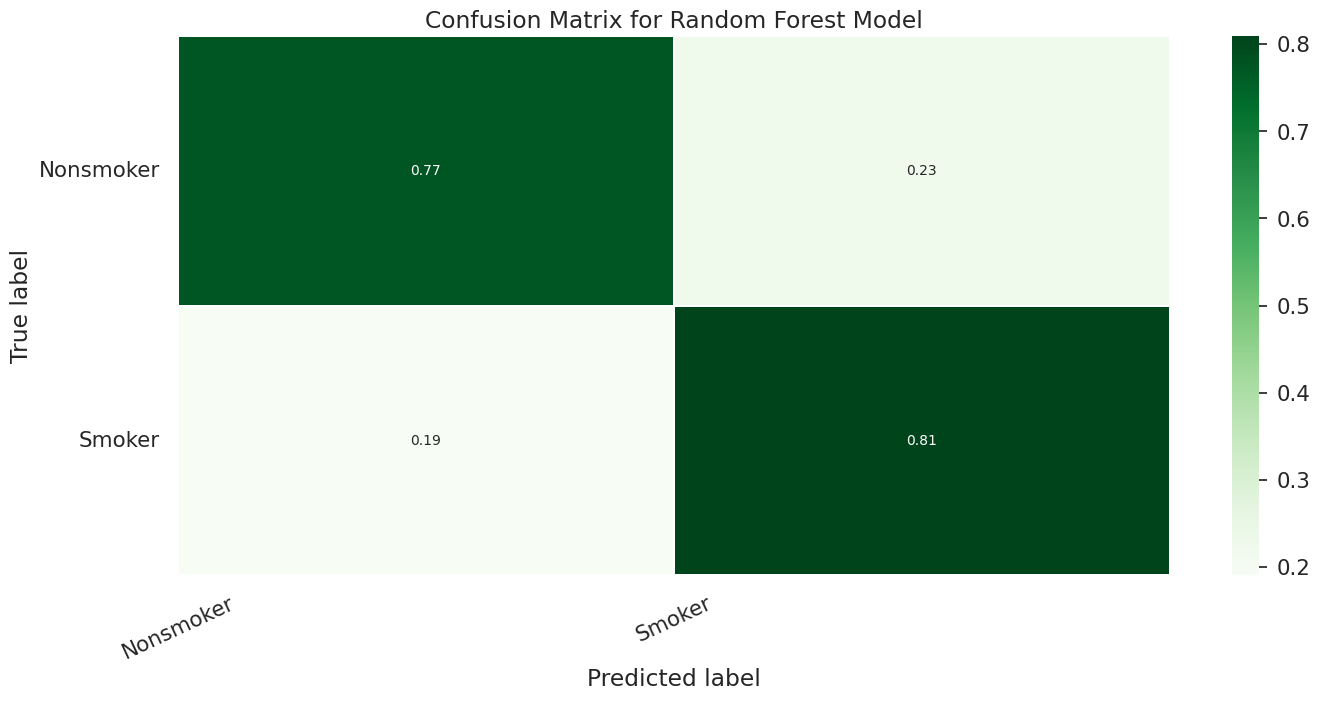

In [ ]:
# Normalize the confusion matrix and visualize it with a heatmap to assess the RandomForestClassifier's accuracy in classifying smokers and nonsmokers.

matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Nonsmoker', 'Smoker']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
# Output the classification report detailing precision, recall, f1-score, and support for the RandomForestClassifier's predictions.

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81     31210
           1       0.72      0.81      0.76     22527

    accuracy                           0.79     53737
   macro avg       0.79      0.79      0.79     53737
weighted avg       0.80      0.79      0.79     53737



In [ ]:
# Calculate the False Positive Rate, True Positive Rate, and Area Under the ROC Curve for the RandomForestClassifier's predictions.

fpr, tpr, _ = roc_curve(y_test,  y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
roc_auc

0.7916292595277493

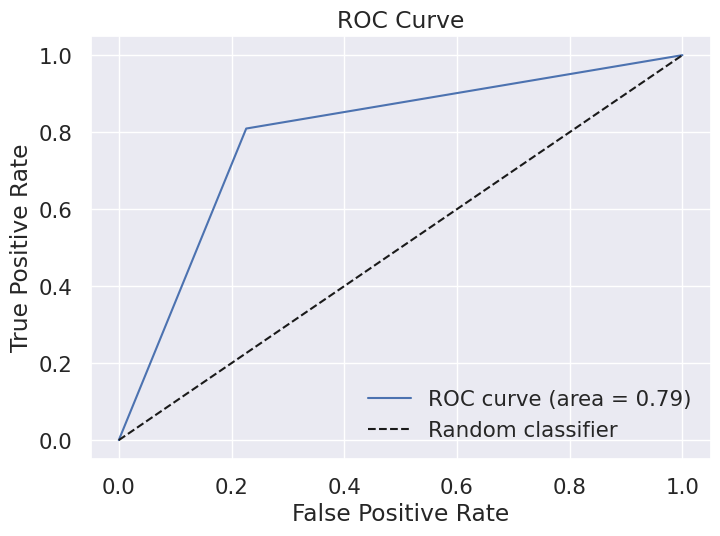

In [ ]:
# Plot the ROC curve for the RandomForestClassifier and compare it to a baseline random classifier.

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, 'Global Feature Importance')

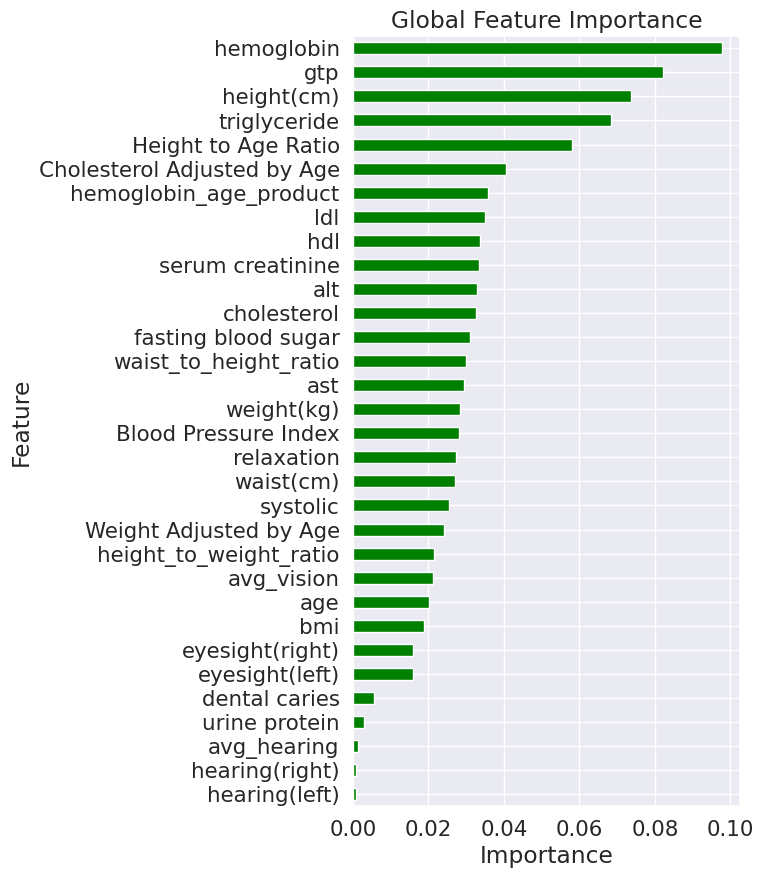

In [ ]:
# Visualize the feature importances from the RandomForestClassifier in a horizontal bar chart, sorted in ascending order.

plt.figure(figsize=(5,10))
global_importances = pd.Series(estimator.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance")

From the feature importances, we can see that hemoglobin, gtp, and height come out as some of the most predictive features. This aligns with what we expect based off the correlation matrix and EDA as hemoglobin and height were predictive features then as well. Some features (such as weight) were correlated with smoking but are not very high in the feature importance. This may be because weight is correlated with other predictive features (such as height) but does not display unique importance.

In [125]:
# Initialize 'random_search' to None, potentially to reset or prepare for a new hyperparameter tuning process.

random_search = None

###8.2.2 XGBoost

XGBoost, or Extreme Gradient Boosting, is renowned for its exceptional predictive performance, making it a top choice for tasks where accuracy is crucial. However, this predictive power comes at the cost of reduced interpretability. XGBoost's ensemble of decision trees can be challenging to interpret compared to simpler models like linear regression or decision trees. While feature importance scores offer some insight, understanding complex feature interactions can be intricate. To balance this trade-off, practitioners may use techniques like feature selection or partial dependence plots to enhance interpretability when needed, aligning the choice between predictive power and interpretability with project goals.

Our objective was to train a Gradient Boosting Regression model using the XGBClassifier. This ensemble technique addresses the underfitting challenge by amalgamating several weaker models to form a more robust one. Furthermore, it excels at capturing intricate nonlinear relationships within the data. It's important to note that we refrained from employing PCA-transformed data with this method, as it is tailored to tree-based models, and PCA transformation is unnecessary in this context.

Additionally, as we will see below, the random forest model overfit on the data. Overfitting is reduced with the help of regularization parameters in XGBoost that helps to select features based on weak and strong features in the decision tree.

In [80]:
# Conduct Grid Search Cross-Validation for an XGBoost classifier with a specified parameter grid, fit the model, and print the best hyperparameters and accuracy on the test set.

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

random_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, n_jobs=1, verbose=2)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Make predictions on the test set using the best model
y_pred = random_search.predict(X_test)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", xgb_accuracy)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END gamma=0, n_estimators=50, reg_alpha=0, reg_lambda=0; total time=   1.6s
[CV] END gamma=0, n_estimators=50, reg_alpha=0, reg_lambda=0; total time=   1.6s
[CV] END gamma=0, n_estimators=50, reg_alpha=0, reg_lambda=0; total time=   4.8s
[CV] END gamma=0, n_estimators=50, reg_alpha=0, reg_lambda=0; total time=   1.5s
[CV] END gamma=0, n_estimators=50, reg_alpha=0, reg_lambda=0; total time=   1.6s
[CV] END gamma=0, n_estimators=50, reg_alpha=0, reg_lambda=0.1; total time=   1.5s
[CV] END gamma=0, n_estimators=50, reg_alpha=0, reg_lambda=0.1; total time=   1.6s
[CV] END gamma=0, n_estimators=50, reg_alpha=0, reg_lambda=0.1; total time=   1.6s
[CV] END gamma=0, n_estimators=50, reg_alpha=0, reg_lambda=0.1; total time=   1.5s
[CV] END gamma=0, n_estimators=50, reg_alpha=0, reg_lambda=0.1; total time=   4.8s
[CV] END gamma=0, n_estimators=50, reg_alpha=0.1, reg_lambda=0; total time=   1.5s
[CV] END gamma=0, n_estimators=50, 

If 'random_search' is not initialized, train an XGBoost Classifier with specified settings, else use the model from 'random_search'.

In [127]:


import xgboost as xgb

if random_search == None:
  xgb_classifier =  xgb.XGBClassifier(objective='binary:logistic', random_state=42, max_depth=None, n_estimators=100, gamma=0.1, reg_alpha=0.1, reg_lambda=0.1)

  xgb_classifier.fit(X_train, y_train)

  # Make predictions on the test set using the best model
  y_pred = xgb_classifier.predict(X_test)

  # Evaluate the model
  xgb_accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", xgb_accuracy)
else:
  xgb_classifier = random_search.best_estimator_

Accuracy: 0.7768390494445168


In [128]:
# Use the trained XGBoost classifier to predict labels on the test dataset.

estimator = xgb_classifier
y_pred_test = xgb_classifier.predict(X_test)

In [83]:
confusion_matrix(y_test, y_pred_test)

array([[24216,  6994],
       [ 4828, 17699]])

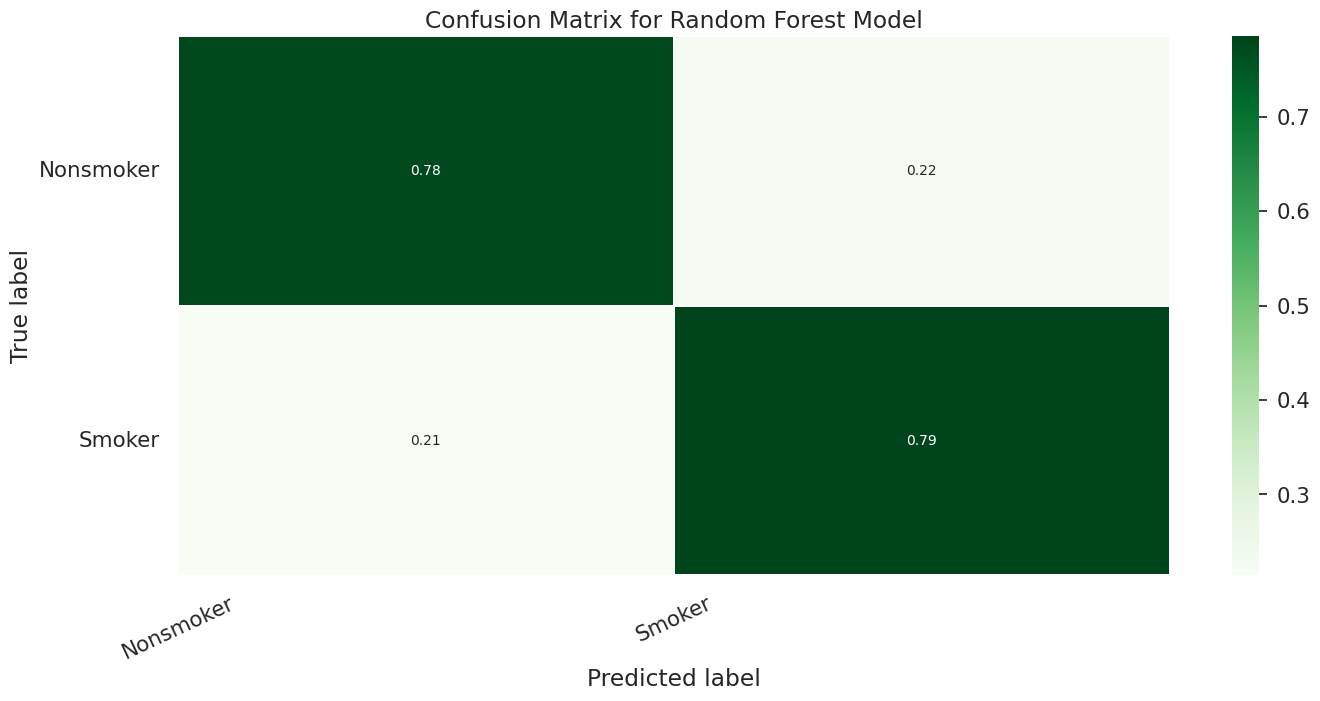

In [84]:
# Normalize the confusion matrix for the XGBoost classifier and visualize it as a heatmap to evaluate its classification performance.

matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Nonsmoker', 'Smoker']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [85]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.78      0.80     31210
           1       0.72      0.79      0.75     22527

    accuracy                           0.78     53737
   macro avg       0.78      0.78      0.78     53737
weighted avg       0.78      0.78      0.78     53737



In [86]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
roc_auc

0.7807922827684568

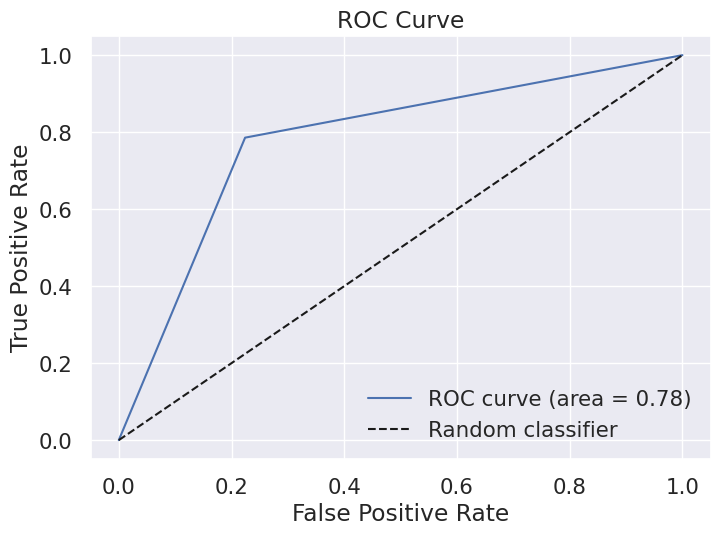

In [87]:
# Plotting the Receiver Operating Characteristic (ROC) curve to visualize classifier performance.
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

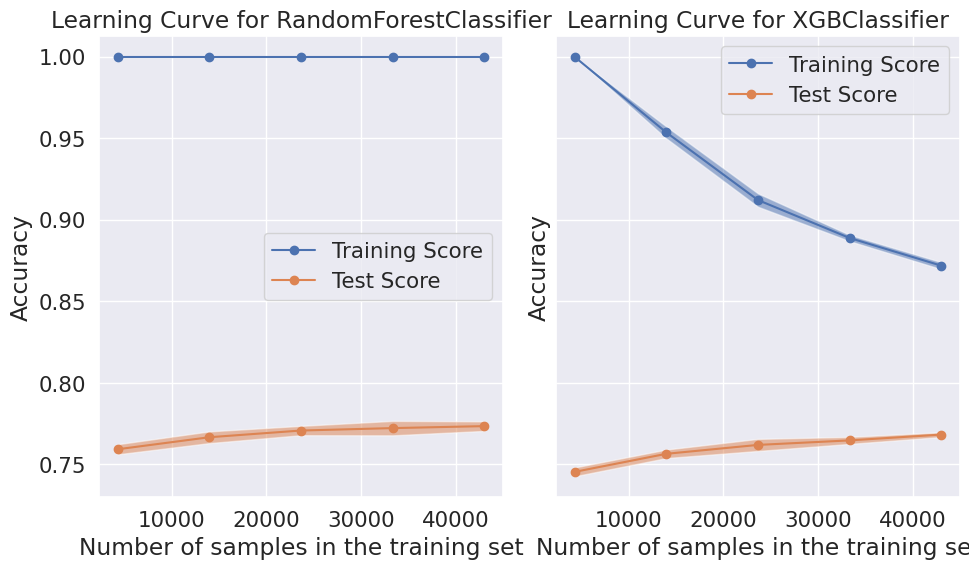

In [129]:
#Generating learning curves for two classifiers (Random Forest and XGBoost) to assess their performance and overfitting.


from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_test,
    "y": y_test,
    "cv": ShuffleSplit(n_splits=5, train_size=0.8, test_size=0.2, random_state=42),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([rf_classifier, xgb_classifier]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")
    plt.tight_layout()

**As we can see above, RF is overfitting significantly more. This makes sense given how XGBoost can decrease overfitting with regularization. Regardless, with the overfitting, we try a less complex model.**

##8.3.1 K-Nearest Neighbors (KNN)

The K-Nearest Neighbors (KNN) algorithm leans more towards predictive power than interpretability. It excels in making predictions, particularly when the relationships between features and outcomes are complex. However, its interpretability is relatively low because it doesn't provide a clear understanding of how individual features contribute to predictions. KNN essentially relies on the similarity of data points in the feature space, making it challenging to extract meaningful insights from the model. While KNN is strong in predictive tasks, it may not be the first choice when interpretability is a primary concern.

The K-Nearest Neighbors (KNN) algorithm is favored for its simplicity and adaptability, excelling in both classification and regression tasks. It operates on the principle that similar data points are close in feature space, making it effective for capturing non-linear relationships and versatile for various datasets. KNN requires no assumptions about data distribution, is robust to outliers, and boasts quick model development with no extensive training phase. Its interpretability makes it accessible to non-experts. However, optimal performance relies on tuning hyperparameters like the number of neighbors (k) and the distance metric, acknowledging that KNN's strength lies in its capacity to handle diverse, non-linear datasets.

In [26]:
grid_search = None

Performing hyperparameter tuning for a k-NN classifier using GridSearchCV and evaluating its accuracy on the test set:

In [32]:
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for k-NN
param_grid = {
    'n_neighbors': [1, 10, 20, 50, 100]
}

# Create a k-NN classifier
knn_classifier = KNeighborsClassifier()

# Create GridSearchCV with 5-fold cross-fvalidation
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train_pca, y_train_pca)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Make predictions on the test set using the best model
y_pred = grid_search.predict(X_test_pca)

# Evaluate the model
knn_accuracy = accuracy_score(y_test_pca, y_pred)
print("Accuracy:", knn_accuracy)

Best Hyperparameters: 20
Accuracy: 0.7241751493384446


**THE ABOVE HYPERPARAMETER TUNING TAKES A WHILE TO RUN. RUN THE CELL BELOW TO JUST INSTANTIATE A KNN WITH THE IDEAL HYPERPARAMETERS WHICH WE LEARNED FROM TUNING**

In [27]:
#If a grid search was not performed, create a k-NN classifier with 20 neighbors and evaluate its
# accuracy on the test set; otherwise, use the result of the grid search.

from sklearn.neighbors import KNeighborsClassifier
if grid_search == None:
  knn_classifier =  KNeighborsClassifier(n_neighbors=20)

  knn_classifier.fit(X_train_pca, y_train_pca)

  # Make predictions on the test set using the best model
  y_pred = knn_classifier.predict(X_test_pca)

  # Evaluate the model
  knn_accuracy = accuracy_score(y_test_pca, y_pred)
  print("Accuracy:", knn_accuracy)
else:
  knn_classifier = grid_search.best_estimator_

Accuracy: 0.7240634944265589


In [ ]:
estimator = knn_classifier
y_pred_test = estimator.predict(X_test_pca)

In [36]:
confusion_matrix(y_test_pca, y_pred_test)

array([[22771,  8439],
       [ 6383, 16144]])

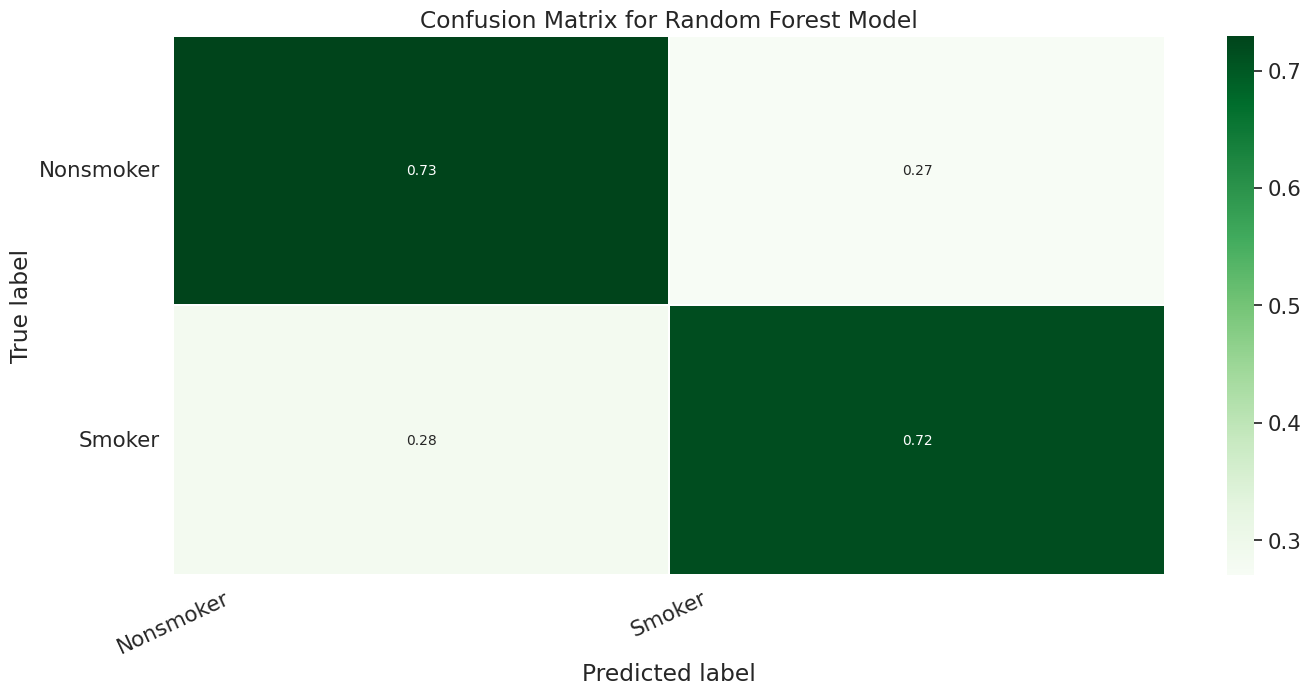

In [37]:
#Creating a heatmap of the normalized confusion matrix to visualize the performance of the Random Forest model.

matrix = confusion_matrix(y_test_pca, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Nonsmoker', 'Smoker']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [38]:
print(classification_report(y_test_pca, y_pred_test))

              precision    recall  f1-score   support

           0       0.78      0.73      0.75     31210
           1       0.66      0.72      0.69     22527

    accuracy                           0.72     53737
   macro avg       0.72      0.72      0.72     53737
weighted avg       0.73      0.72      0.73     53737



In [39]:
fpr, tpr, _ = roc_curve(y_test_pca,  y_pred_test)
roc_auc = roc_auc_score(y_test_pca, y_pred_test)
roc_auc

0.723128512650852

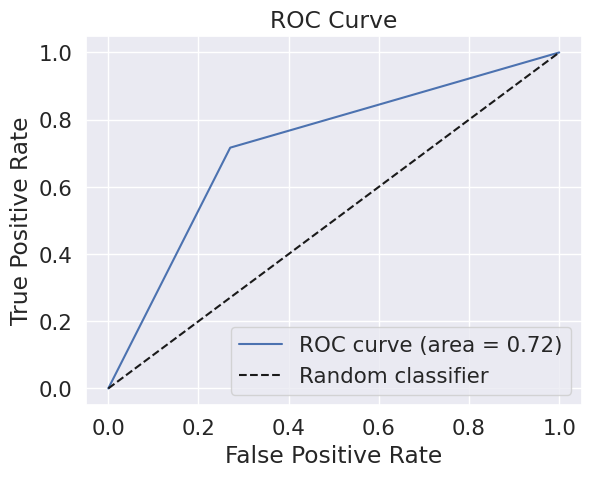

In [40]:
# Visualizing the Receiver Operating Characteristic (ROC) curve to assess classifier performance.
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Generate a learning curve for a k-NN classifier using cross-validation with specified parameters.
Customize the plot by adding legends, titles, and specifying training and test scores:


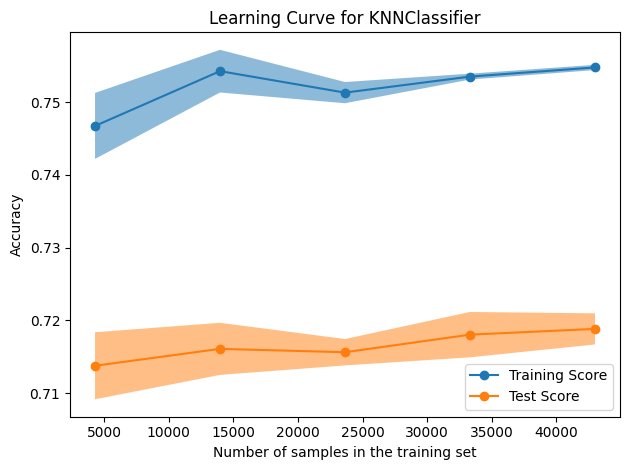

In [31]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
fig, ax = plt.subplots()

common_params = {
    "X": X_test_pca,
    "y": y_test_pca,
    "cv": ShuffleSplit(n_splits=2, train_size=0.8, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(knn_classifier, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for KNNClassifier")
fig.tight_layout()

**KNN significantly undefits. This makes sense given its simplicity. Thus, we try a more complex model**

##8.4.1 Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis (LDA) strikes a balance between predictive power and interpretability. It performs well when the underlying relationships in the data are approximately linear, making it a robust predictor. LDA also provides insights into feature importance through the linear combinations of features it uses to discriminate between classes. While LDA offers reasonable interpretability, it may not capture complex, non-linear relationships as effectively as some other models. Therefore, its interpretability is moderate, making it a versatile choice for various scenarios where both predictive performance and some degree of interpretability are desired.

Linear Discriminant Analysis (LDA) is a valuable technique used for classification and dimensionality reduction, making it particularly advantageous in situations where the goal is to differentiate among multiple classes by leveraging linear combinations of features. LDA proves most effective when specific assumptions are met, such as the presence of Gaussian-distributed classes and homogeneity of covariance matrices across classes. By maximizing the between-class variance relative to within-class variance, LDA identifies linear discriminants that excel at capturing essential features for class separation. Moreover, LDA offers substantial benefits when dealing with high-dimensional data, as it yields a lower-dimensional representation that retains the critical aspects of class separability. This method finds applications in various fields, including face recognition, speech processing, and medical diagnostics, where the primary objective is distinguishing among multiple classes through linear combinations of features.

One notable advantage of LDA is that it doesn't require feature scaling prior to application. This is because LDA components are not influenced by the relative feature ranges, simplifying the preprocessing steps and offering convenience when working with diverse datasets.

In [130]:
grid_search = None

Perform hyperparameter tuning for Linear Discriminant Analysis (LDA) classifier
using GridSearchCV with 5-fold cross-validation and evaluate its accuracy on the test set.


In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid = {
    'shrinkage': [None, 'auto'],
}

# Create an LDA classifier
lda_classifier = LinearDiscriminantAnalysis()

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(lda_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
lda_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", lda_accuracy)

Best Hyperparameters: {'shrinkage': None}
Accuracy: 0.7491300221448909


If a grid search was not performed, create an LDA classifier with shrinkage=None,
fit it to the training data, and evaluate its accuracy on the test set.
 Otherwise, use the result of the grid search.


In [131]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

if grid_search == None:
  lda_classifier =  LinearDiscriminantAnalysis(shrinkage=None)

  lda_classifier.fit(X_train, y_train)

  # Make predictions on the test set using the best model
  y_pred = lda_classifier.predict(X_test)

  # Evaluate the model
  lda_accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", lda_accuracy)
else:
  lda_classifier = grid_search.best_estimator_

Accuracy: 0.7491300221448909


In [132]:
# Use the Linear Discriminant Analysis (LDA) classifier (estimator) to make predictions on the test data.

estimator = lda_classifier
y_pred_test = estimator.predict(X_test)

In [36]:
confusion_matrix(y_test, y_pred_test)

array([[22681,  8529],
       [ 4952, 17575]])

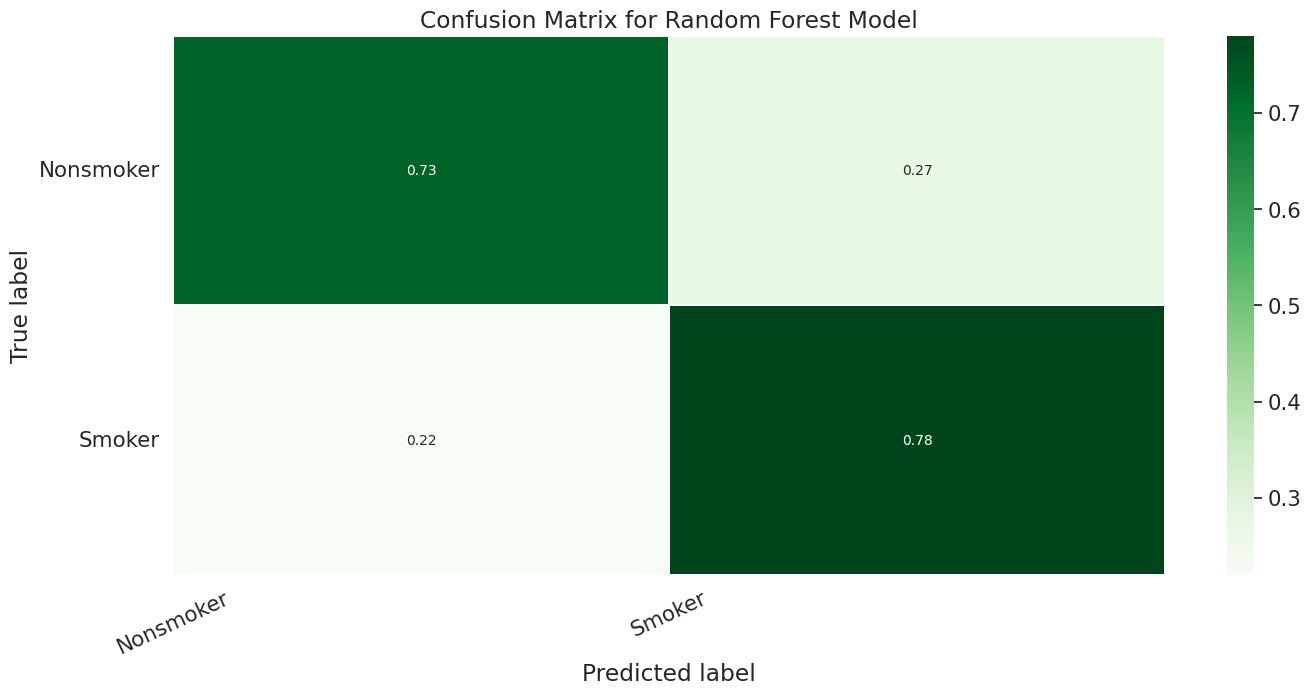

In [37]:
# Calculate and normalize the confusion matrix for model evaluation,
# then create a heatmap to visualize it, and add labels and title for clarity.

matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Nonsmoker', 'Smoker']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [38]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77     31210
           1       0.67      0.78      0.72     22527

    accuracy                           0.75     53737
   macro avg       0.75      0.75      0.75     53737
weighted avg       0.76      0.75      0.75     53737



In [39]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
roc_auc

0.7534485528256476

 Plotting the Receiver Operating Characteristic (ROC) curve to visualize classifier performance.
 Also, including a reference line for a random classifier, labeling axes, and adding a legend.


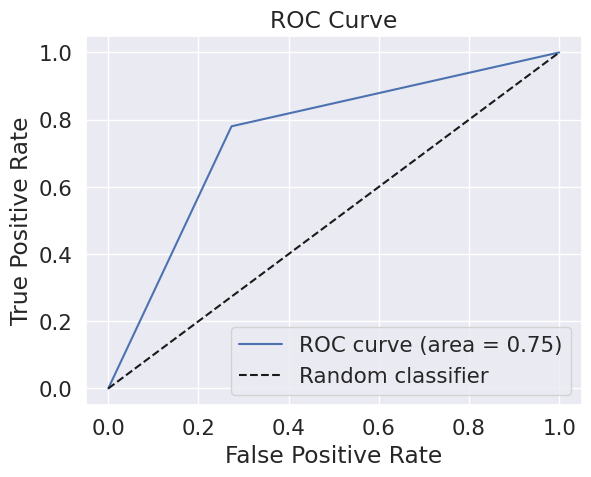

In [40]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

##8.4.2 Quadratic Discriminant Analysis (QDA)


We compare LDA against Quadratic Discriminant Analysis (QDA), which prioritizes predictive power over interpretability. It excels in capturing complex, non-linear relationships in the data, making it a powerful predictor. However, the trade-off is reduced interpretability compared to simpler models like LDA, as QDA estimates separate covariance matrices for each class, which can make it challenging to interpret the specific relationships between features and classes. Therefore, QDA is a strong choice when predictive accuracy is paramount, but it sacrifices some interpretability in exchange for its ability to model intricate data patterns.

QDA stands as a classification method that offers an advantageous alternative when the assumption of equal covariance matrices across classes, which is fundamental in Linear Discriminant Analysis (LDA), may not hold true. Distinguishing itself from LDA, QDA permits distinct covariance matrices for each class, granting the flexibility needed to model intricate and non-linear decision boundaries. QDA shines particularly in scenarios where classes exhibit diverse and varying variances. However, it's essential to acknowledge that QDA may have a higher propensity for overfitting, especially in cases with limited data, as it estimates separate covariance matrices for each class. The decision to employ QDA or LDA hinges upon the inherent characteristics of the data and the significance of class-specific covariances in accurately depicting class distributions.

An additional advantage of QDA is that it does not necessitate feature scaling beforehand. This is attributed to the fact that QDA components remain unaffected by the relative ranges of the features. This attribute simplifies the preprocessing steps and renders QDA suitable for datasets with diverse feature scales.

In [133]:
grid_search = None

In [42]:
# Perform hyperparameter tuning for Quadratic Discriminant Analysis (QDA) classifier
# using GridSearchCV with 5-fold cross-validation and evaluate its accuracy on the test set.

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Define the parameter grid for QDA
param_grid = {
    'tol': [1e-3, 1e-2, 1e-1]
}

# Create a QDA classifier
qda_classifier = QuadraticDiscriminantAnalysis()

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(qda_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
qda_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", qda_accuracy)

Best Hyperparameters: {'tol': 0.001}
Accuracy: 0.7215326497571506


If a grid search was not performed, create a Quadratic Discriminant Analysis (QDA) classifier
with a specified tolerance (tol=0.001), fit it to the training data, and evaluate its accuracy on the test set.
Otherwise, use the result of the grid search as the QDA accuracy.


In [134]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

if grid_search == None:
  qda_classifier =  QuadraticDiscriminantAnalysis(tol=0.001)

  qda_classifier.fit(X_train, y_train)

  # Make predictions on the test set using the best model
  y_pred = qda_classifier.predict(X_test)

  # Evaluate the model
  qda_accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", qda_accuracy)
else:
  qda_classifier = grid_search

Accuracy: 0.7215326497571506


In [135]:
estimator = qda_classifier
y_pred_test = estimator.predict(X_test)

In [45]:
confusion_matrix(y_test, y_pred_test)

array([[19807, 11403],
       [ 3561, 18966]])

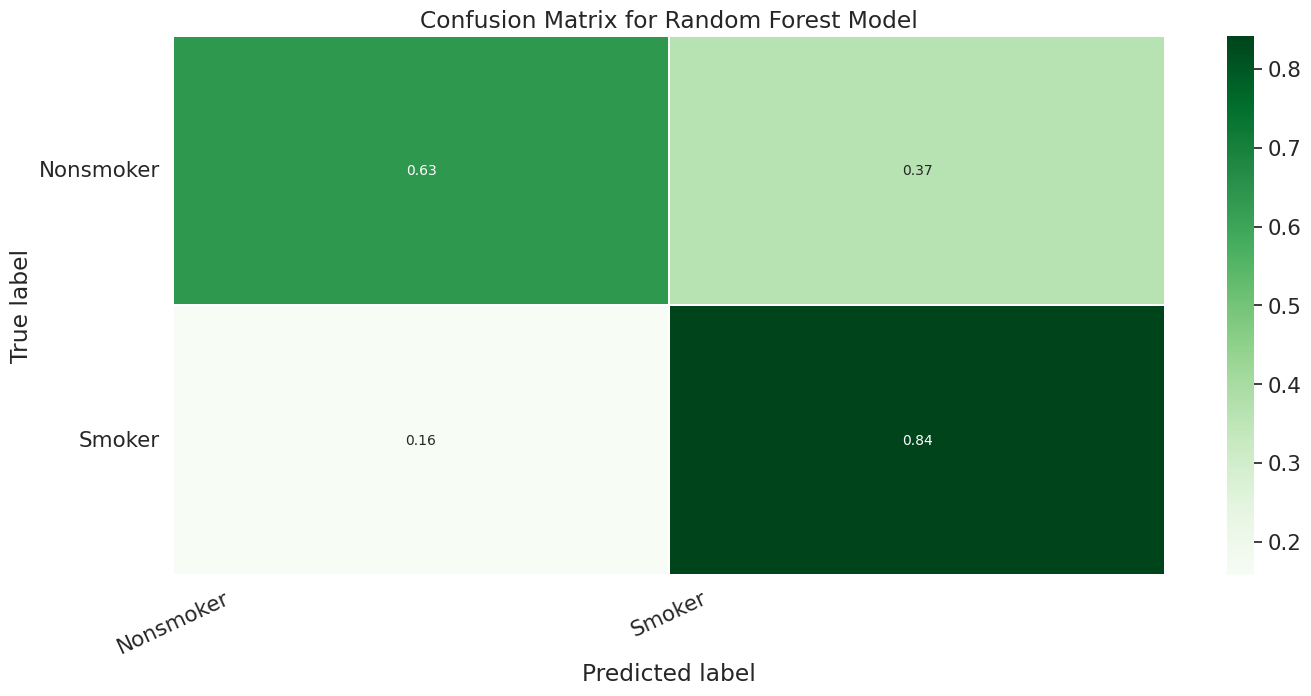

In [46]:
# Calculate and normalize the confusion matrix, then create a heatmap to visualize it.
# Add labels, title, and adjust plot settings for better readability.

matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Nonsmoker', 'Smoker']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [47]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.63      0.73     31210
           1       0.62      0.84      0.72     22527

    accuracy                           0.72     53737
   macro avg       0.74      0.74      0.72     53737
weighted avg       0.75      0.72      0.72     53737



In [48]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
roc_auc

0.7382796801053304

Visualizing the Receiver Operating Characteristic (ROC) curve and a random classifier line.
Adding labels, title, legend, and displaying the ROC curve plot for model evaluation.

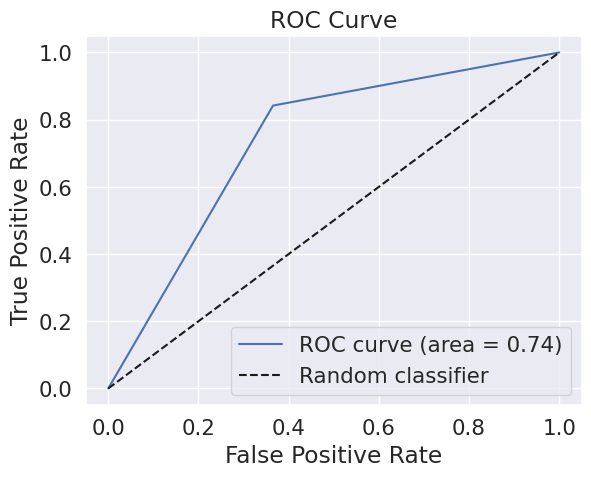

In [49]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

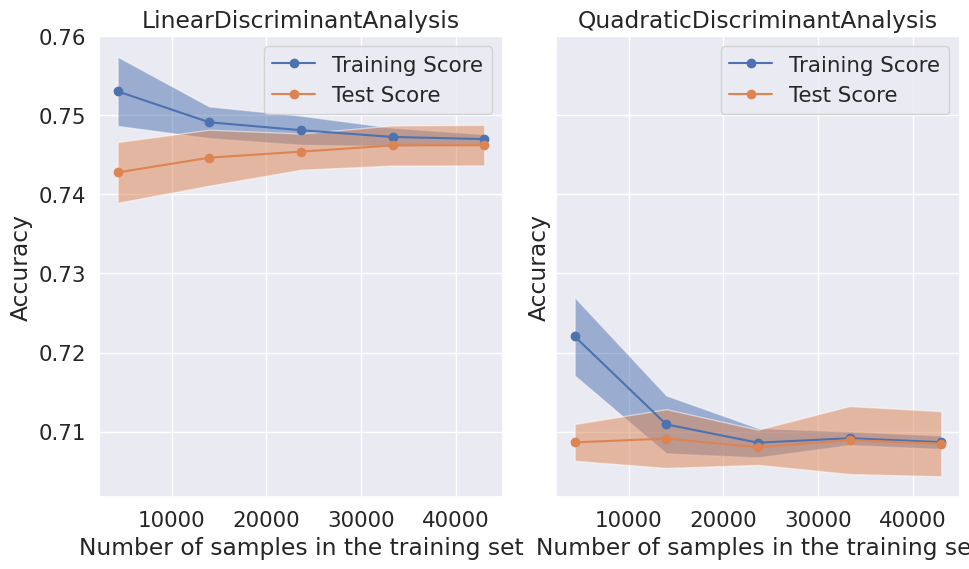

In [185]:
# Creating subplots for learning curves of different estimators (LDA and QDA) side by side.
# Utilizing common parameters and customizing each subplot for model evaluation visualization.

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_test,
    "y": y_test,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([lda_classifier, qda_classifier]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"{estimator.__class__.__name__}")
    plt.tight_layout()



**Both LDA and QDA significantly overfit and underperform compared to the tree based methods. Thus, we return to the tree based methods. However, we seek to reduce the overfitting in the RF**

##8.5.1 ExtraTreesClassifier

The ExtraTreesClassifier emphasizes predictive power over interpretability. It excels in producing accurate predictions, especially when dealing with high-dimensional or noisy datasets, thanks to its randomized decision tree-building process. However, this enhanced predictive ability comes at the cost of reduced interpretability. The additional randomness introduced during tree construction makes it challenging to extract meaningful insights from the model. Therefore, the ExtraTreesClassifier is a preferred choice when the primary goal is achieving top-notch predictive performance, while interpretability takes a back seat in the modeling process.

The ExtraTreesClassifier, a variation of the Random Forest algorithm, introduces additional randomness in the tree-building process, enhancing model diversity and robustness. This feature is especially beneficial when striving for a highly adaptable model. ExtraTrees excels in scenarios with abundant features or instances, as it employs random feature selection and threshold selection for node splits, resulting in a more diverse tree ensemble. This diversity reduces the risk of overfitting and proves advantageous for handling noisy or high-dimensional datasets. Additionally, ExtraTrees boasts faster training times compared to traditional Random Forests, making it ideal for large datasets. However, increased randomness may reduce model interpretability, necessitating careful hyperparameter selection for optimal performance.

Similar to the Random Forest algorithm, the ExtraTreesClassifier also exhibits scale invariance, eliminating the need for feature scaling before application.  However, in an Extra Trees classifier, the features and splits are selected at random (as opposed to optimally as done by an RF). Thus, extra trees is at less risk to overfit

In [53]:
random_search = None

In [55]:
# Perform hyperparameter tuning for an Extra Trees Classifier using GridSearchCV with 5-fold cross-validation.
# Evaluate the model's accuracy on the test set after finding the best hyperparameters.

from sklearn.ensemble import ExtraTreesClassifier
from random import randint

param_dist = {
    'n_estimators': [10, 20, 100],
    'max_depth': [None, 3, 5, 7],
}

# Create an ExtraTreesClassifier
extra_trees_classifier = ExtraTreesClassifier(random_state=42)

# Create GridSearch with 5-fold cross-validation
random_search = GridSearchCV(extra_trees_classifier, param_dist, cv=5, scoring='accuracy', n_jobs=-1)


# Fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Make predictions on the test set using the best model
y_pred = random_search.predict(X_test)

# Evaluate the model
et_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", et_accuracy)

Best Hyperparameters: {'max_depth': None, 'n_estimators': 100}
Accuracy: 0.7783463907549732


If a random search was not performed, create an Extra Trees Classifier with specified hyperparameters,
fit it to the training data, and evaluate its accuracy on the test set.
Otherwise, use the result of the random search as the Extra Trees Classifier.


In [65]:
if random_search == None:
  extra_trees_classifier = ExtraTreesClassifier(max_depth = None, n_estimators=100)

  extra_trees_classifier.fit(X_train, y_train)

  # Make predictions on the test set using the best model
  y_pred = extra_trees_classifier.predict(X_test)

  # Evaluate the model
  et_accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", et_accuracy)
else:
  extra_trees_classifier = random_search.best_estimator_

In [57]:
# Assign the Extra Trees Classifier (estimator) to make predictions on the test data.
# Store the predictions in y_pred_test for further evaluation.

estimator = extra_trees_classifier
y_pred_test = estimator.predict(X_test)

In [58]:
confusion_matrix(y_test, y_pred_test)

array([[23727,  7483],
       [ 4428, 18099]])

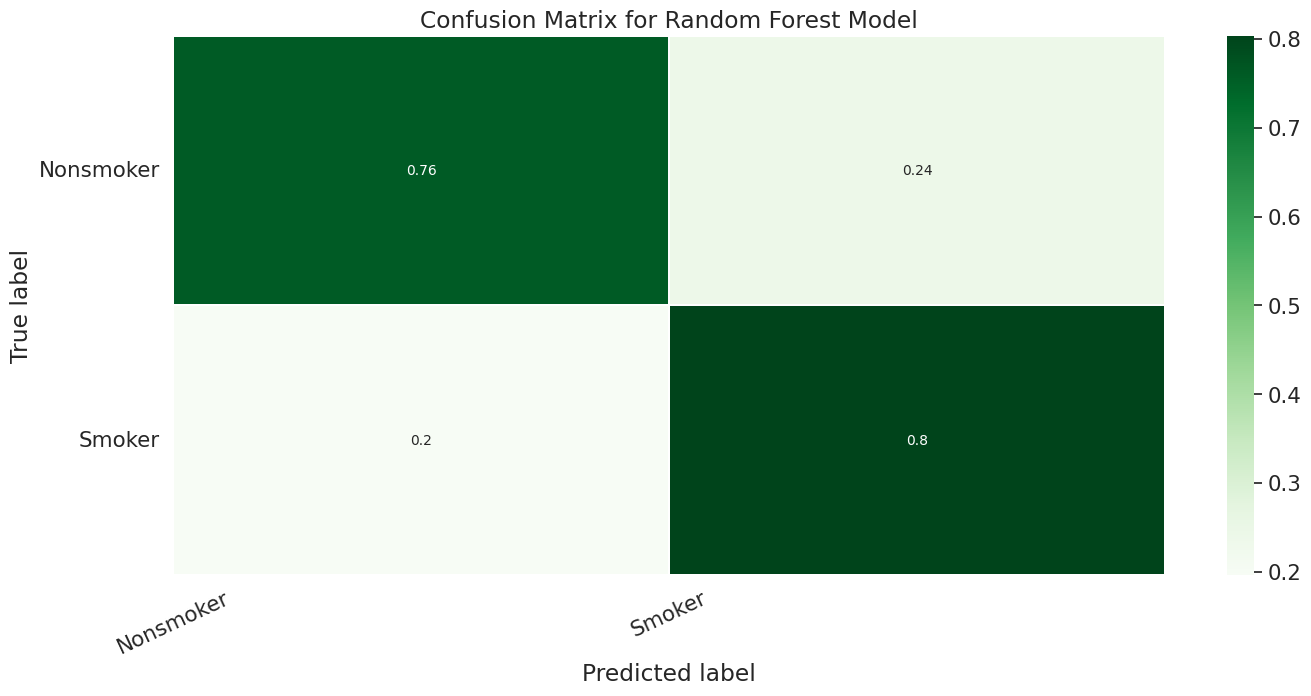

In [59]:
# Calculate and normalize the confusion matrix for model evaluation, then create a heatmap plot.
# Customize the plot with annotations, class labels, and other visual enhancements for clarity.

matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Nonsmoker', 'Smoker']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [60]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80     31210
           1       0.71      0.80      0.75     22527

    accuracy                           0.78     53737
   macro avg       0.78      0.78      0.78     53737
weighted avg       0.79      0.78      0.78     53737



In [61]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
roc_auc

0.7818364902200666

Plotting the Receiver Operating Characteristic (ROC) curve to visualize classifier performance.
Including a reference line for a random classifier, labeling axes, and adding a legend:


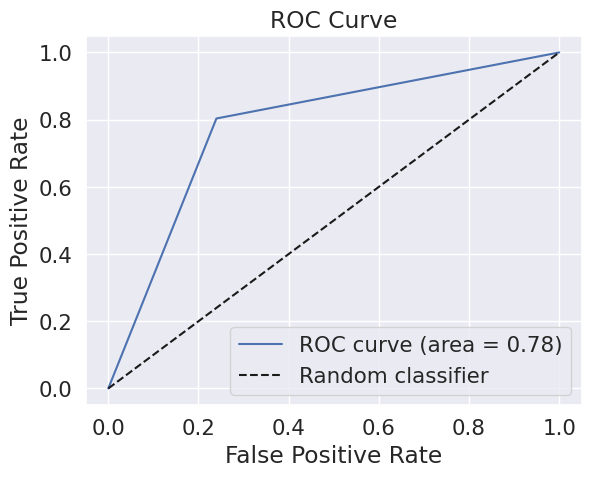

In [62]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


##8.5.2 CatBoost

CatBoost prioritizes predictive power over interpretability. It stands out for its ability to handle categorical features effectively without extensive preprocessing, enhancing predictive accuracy. The algorithm incorporates advanced techniques like ordered boosting and optimized strategies for faster convergence, contributing to its exceptional predictive performance. However, the increased complexity introduced by these techniques can make CatBoost models challenging to interpret. Therefore, CatBoost is a go-to choice when the primary objective is achieving superior predictive accuracy, even if it means sacrificing some level of model interpretability.

CatBoost an advanced gradient boosting algorithm developed by Yandex, brings a suite of advantages to the realm of machine learning. One standout feature is its remarkable capability to seamlessly manage categorical features without necessitating extensive preprocessing, thereby mitigating the risk of information loss during the encoding process. CatBoost introduces a cutting-edge technique called ordered boosting, which skillfully addresses overfitting concerns and expedites training by introducing an innovative symmetric tree structure. The algorithm further harnesses the power of advanced optimization strategies, including oblivious trees and dynamic learning rate scheduling, leading to accelerated convergence and robust performance across a diverse range of datasets. Additionally, CatBoost seamlessly integrates with GPUs, offering expedited training times, particularly beneficial for handling large datasets. Its innate support for categorical features, adept overfitting management, and optimization prowess solidify CatBoost's standing as a compelling choice for practitioners seeking a potent and user-friendly gradient boosting solution.

Furthermore, it's worth noting that PCA data is not utilized in CatBoost, as it operates as a tree-based method with distinct characteristics.  Additionally, regularization techniques are used in CatBoost to reduce overfitting and improve generalization. It features L2 regularization on leaf values, which modifies the loss function by adding a penalty term to prevent excessive leaf values.

In [66]:
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.4 MB/s eta 0:00:00


In [67]:
grid_search = None

 Perform hyperparameter tuning for a CatBoostClassifier using GridSearchCV with 5-fold cross-validation.
 Evaluate the model's accuracy on the test set after finding the best hyperparameters.


In [70]:
from catboost import CatBoostClassifier, Pool

# Convert data to CatBoost format
train_data = Pool(data=X_train, label=y_train)
test_data = Pool(data=X_test, label=y_test)

# Define the hyperparameter grid for CatBoost
param_grid = {
    'n_estimators':[100, 200, 300],
    'depth': [3, 5, 7]
}

# Create a CatBoost classifier
catboost_classifier = CatBoostClassifier(random_seed=42, silent=True)

# Create GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(catboost_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train, verbose=False)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Make predictions on the test set using the best model
y_pred = grid_search.predict(test_data)

# Evaluate the model
cat_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", cat_accuracy)

Best Hyperparameters: {'depth': 5, 'n_estimators': 300}
Accuracy: 0.7778067253475259


If a grid search was not performed, create a CatBoostClassifier with specified hyperparameters,
fit it to the training data, and evaluate its accuracy on the test set.
Otherwise, use the result of the grid search as the CatBoostClassifier.

In [71]:
if grid_search == None:
  catboost_classifier = CatBoostClassifier(silent=True, depth=5, n_estimators=300)

  catboost_classifier.fit(X_train, y_train)

  # Make predictions on the test set using the best model
  y_pred = catboost_classifier.predict(X_test)

  # Evaluate the model
  cat_accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", cat_accuracy)
else:
  catboost_classifier = grid_search.best_estimator_

In [72]:
estimator = catboost_classifier
y_pred_test = estimator.predict(X_test)

In [73]:
confusion_matrix(y_test, y_pred_test)

array([[24078,  7132],
       [ 4808, 17719]])

Calculate and normalize the confusion matrix, then create a heatmap plot for visualization.
Customize the plot with annotations, class labels, and other visual settings for clarity.

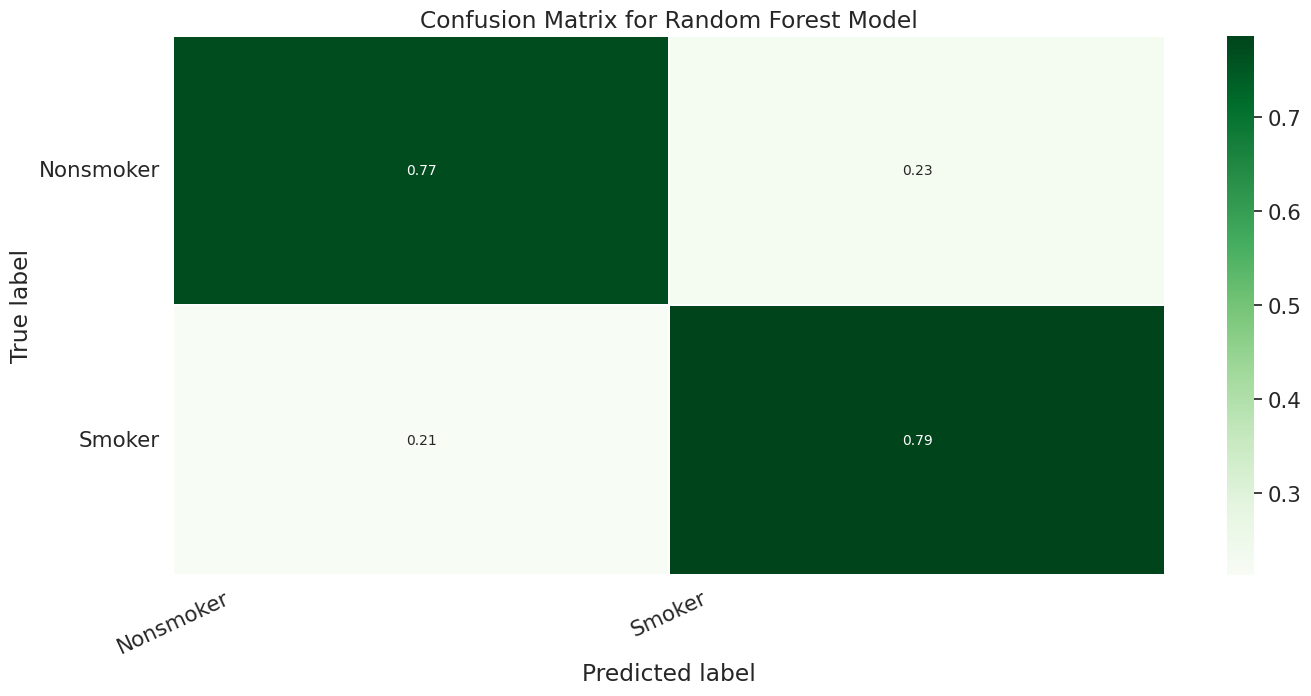

In [74]:
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Nonsmoker', 'Smoker']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [75]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80     31210
           1       0.71      0.79      0.75     22527

    accuracy                           0.78     53737
   macro avg       0.77      0.78      0.77     53737
weighted avg       0.78      0.78      0.78     53737



In [76]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
roc_auc

0.7790253646565771

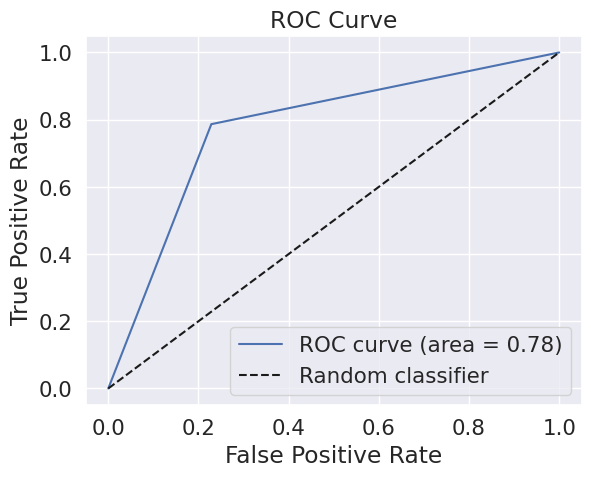

In [77]:
# Plotting the Receiver Operating Characteristic (ROC) curve to visualize classifier performance.
# Including a reference line for a random classifier, labeling axes, and adding a legend for clarity.

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

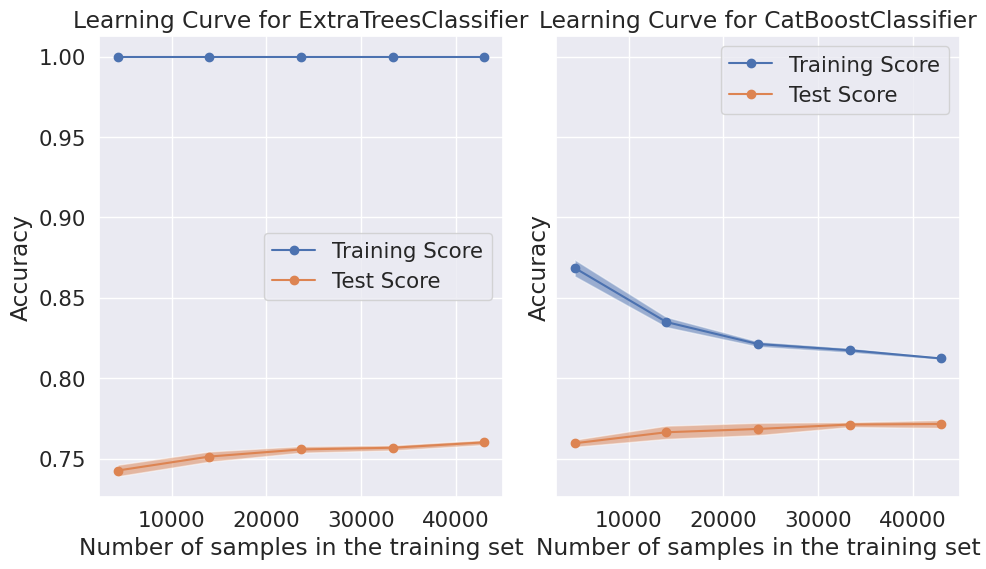

In [80]:
# Create learning curves for different classifiers to visualize their training and testing performance.
# Configure common parameters, iterate through classifiers, and display the learning curves on subplots.

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_test,
    "y": y_test,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([extra_trees_classifier, catboost_classifier]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")
    plt.tight_layout()

**As we can see from the learning curve, ExtraTrees significantly overfits. CatBoost also overfits but less so. Both perform well but not as well as the RF.**

In [86]:
ridge_best_accuracy = 0.7213279490853601
logistic_regression_accuracy = 0.719039023391704
rf_accuracy = 0.788451160280626
xgb_accuracy = 0.7768390494445168
qda_accuracy = 0.7215326497571506
model_performance = pd.DataFrame()
model_performance['Model'] = ['Ridge', 'Logistic', 'RF', 'XGB', 'KNN', 'LDA', 'QDA', 'ET', 'Cat']
model_performance['Accuracy'] = [ridge_best_accuracy, logistic_regression_accuracy, rf_accuracy, xgb_accuracy, knn_accuracy, lda_accuracy, qda_accuracy, et_accuracy, cat_accuracy]
print(f"The following table shows the performance of the considered models: \n\n{model_performance}")

The following table shows the performance of the considered models: 

      Model  Accuracy
0     Ridge  0.721328
1  Logistic  0.719039
2        RF  0.788451
3       XGB  0.776839
4       KNN  0.724063
5       LDA  0.749130
6       QDA  0.721533
7        ET  0.778346
8       Cat  0.777807


#8.6.1 Model Ensemble

For the top 3 models, we create a VotingClassifier Ensemble method.

Ensemble modeling can reduce variance, minimize modeling method bias and thus decrease chances of overfitting. The predictions based on ensemble modelling methods tend to be more stable with lower variance.

In [92]:
# Create a VotingClassifier by combining three top-performing models using soft voting.
# Fit the ensemble model on the training data and evaluate its accuracy on the test set.

from sklearn.ensemble import RandomForestClassifier, VotingClassifier

top_model_1 = rf_classifier
top_model_2 = extra_trees_classifier
top_model_3 = catboost_classifier

# Create a VotingClassifier
voting_classifier = VotingClassifier(
    estimators=[
        ('rf', top_model_1),
        ('et', top_model_2),
        ('cat', top_model_3)
    ],
    voting='soft'  # 'hard' for majority voting, 'soft' for weighted voting based on probabilities
)

# Fit the VotingClassifier on your training data
voting_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
voting_accuracy = voting_classifier.score(X_test, y_test)
print("Voting Classifier Accuracy:", voting_accuracy)


Voting Classifier Accuracy: 0.7914286245975771


In [93]:
ensemble_classifier = voting_classifier

In [94]:
estimator = ensemble_classifier
y_pred_test = estimator.predict(X_test)

In [95]:
confusion_matrix(y_test, y_pred_test)

array([[24132,  7078],
       [ 4130, 18397]])

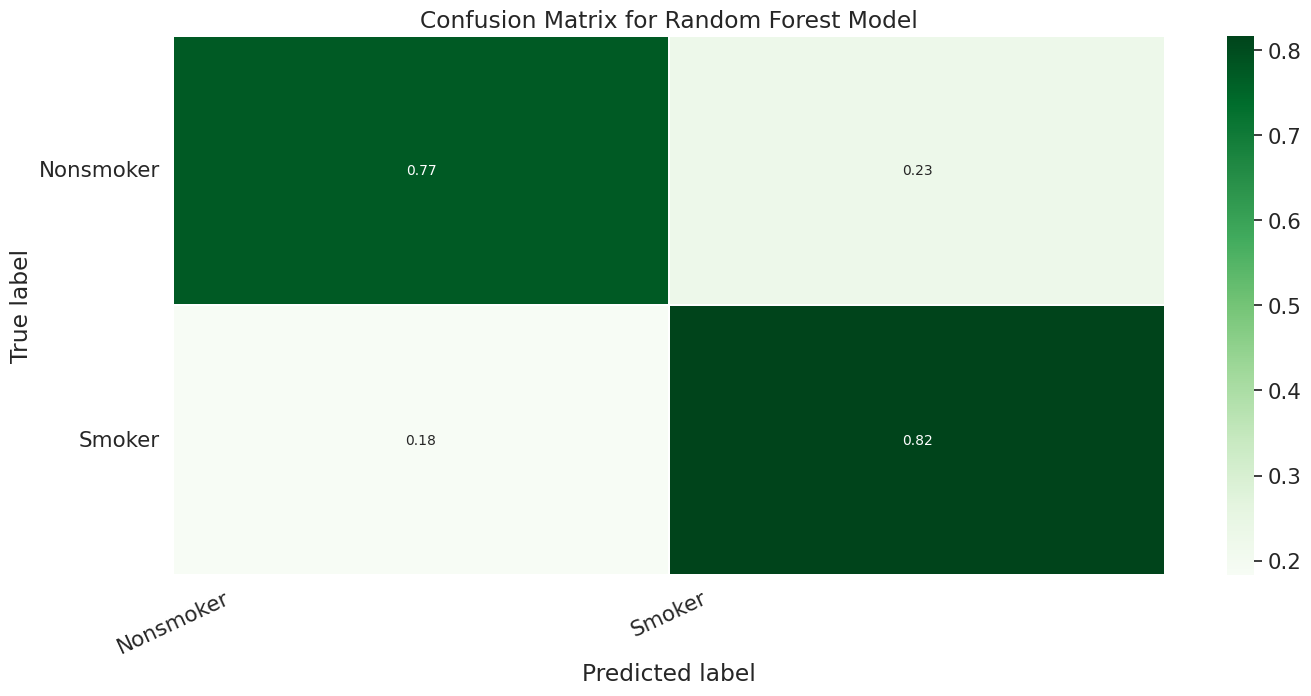

In [96]:

matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Nonsmoker', 'Smoker']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()


In [97]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81     31210
           1       0.72      0.82      0.77     22527

    accuracy                           0.79     53737
   macro avg       0.79      0.79      0.79     53737
weighted avg       0.80      0.79      0.79     53737



In [98]:

fpr, tpr, _ = roc_curve(y_test,  y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
roc_auc


0.7949390803306317

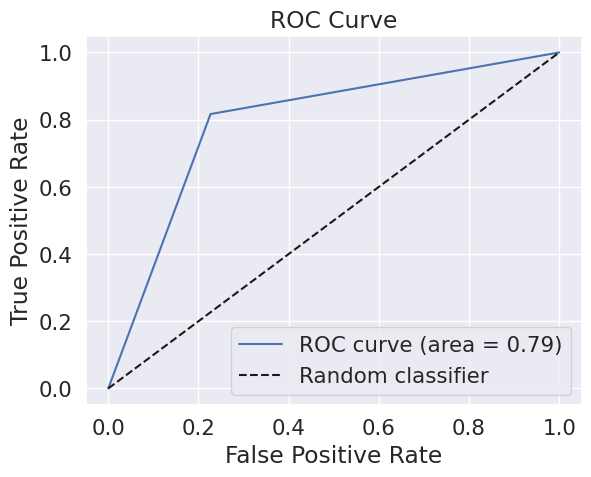

In [99]:

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


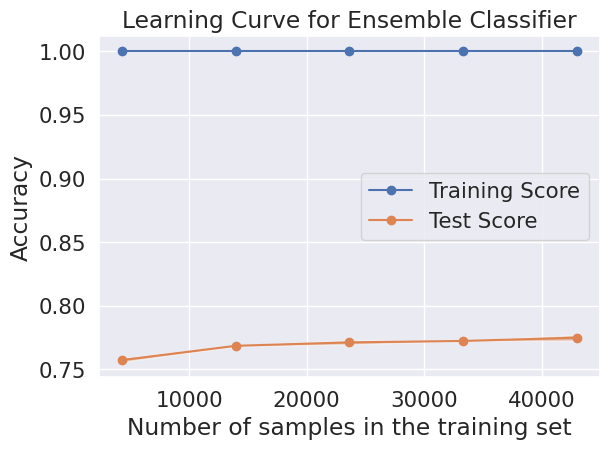

In [103]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
fig, ax = plt.subplots()

common_params = {
    "X": X_test,
    "y": y_test,
    "cv": ShuffleSplit(n_splits=2, train_size=0.8, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for Ensemble Classifier")
fig.tight_layout()

**Although the ensemble model does overfit, it performs the best of all the models with the highest accuracy, precision, and AUC. This is expected as we are ensembling from the best models.**

#8.7.1 NN by pytorch

Although our ensemble already does overfit, we still wanted to try to see what would happen if we increased complexity even more.

Check for GPU availability and set the device accordingly (CPU or GPU).
Convert training and test data to PyTorch tensors and send them to the selected device.


In [104]:
# Sending to GPU if available
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

# Creating tensor from test and training data
X_train_tensor = torch.from_numpy(X_train[0:-1].values).float().to(device)
X_test_tensor = torch.from_numpy(X_test[0:-7].values).float().to(device)
y_train_tensor = torch.from_numpy(y_train[0:-1].values).float().to(device)
y_test_tensor = torch.from_numpy(y_test[0:-7].values).float().to(device)


In [105]:
# Verifying the number of features and rows within the tensors
print(X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape)

torch.Size([161210, 34]) torch.Size([53730, 34]) torch.Size([161210]) torch.Size([53730])


In [106]:
import torch.nn as nn
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return self.sigmoid(x)

In [107]:
import torch.optim as optim
# Defining the loss function and optimizer by which we update the model
net = NN(input_dim=(X_train_tensor.shape[1])).to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [113]:
# Training the neural network
n_epochs = 10
batch_size = 10
batch_start = torch.arange(0, len(X_train_tensor), batch_size)

best_bce = np.inf
bce_history = []
train_history = []

for epoch in range(n_epochs):
  for start in batch_start:
      X_batch = X_train_tensor[start: start + batch_size].to(device)
      y_batch = y_train_tensor[start: start + batch_size].to(device)
      y_pred = net(X_batch).to(device)
      loss = loss_fn(y_pred, y_batch.unsqueeze(dim=1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  train_history.append(loss)
  y_pred = net(X_test_tensor)
  bce = loss_fn(y_pred, y_test_tensor.unsqueeze(dim=1))
  bce = float(bce)
  print(bce)
  bce_history.append(bce)
  if bce < best_bce:
    best_bce = bce
  print("BEST BCE: ", best_bce)

0.486028254032135
BEST BCE:  0.486028254032135
0.4825490415096283
BEST BCE:  0.4825490415096283
0.48570406436920166
BEST BCE:  0.4825490415096283
0.4794054329395294
BEST BCE:  0.4794054329395294
0.4815727174282074
BEST BCE:  0.4794054329395294
0.4845872223377228
BEST BCE:  0.4794054329395294
0.4803304970264435
BEST BCE:  0.4794054329395294
0.4801831841468811
BEST BCE:  0.4794054329395294
0.4865460693836212
BEST BCE:  0.4794054329395294
0.4844859838485718
BEST BCE:  0.4794054329395294


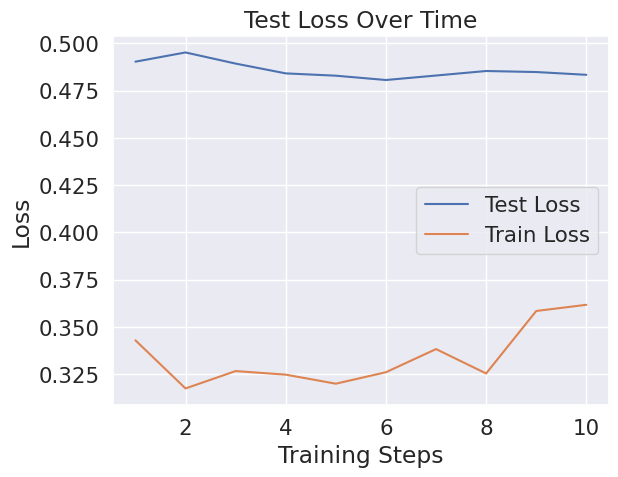

In [179]:
train_steps = range(1, len(bce_history) + 1)

plt.plot(train_steps, bce_history, label='Test Loss')
plt.plot(train_steps, train_history, label='Train Loss')

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Test Loss Over Time')
plt.show()

The results from the NN are not good. It overfits and never really learns. The test loss never decreases (and neither does the train loss significantly decrease). This suggests NN are too complex for our data which makes sense how NN's main uses are for more complex image, language, etc. data

# Part 9. FEATURE ENGINEERING PART 2:

Accounting for genderis crucial because gender can act as a confounding factor, influencing both biosignal and smoking status. We should account for it similarly to how we do with age and rerun our ensemble and NN models.




In [152]:
# Define a function to recalculate features adjusted by gender based on group means.
# Apply this function to the training data and extract recalculated features for analysis.

def recalculate_gender_features(data):

    grouped_hemoglobin = data.groupby(['gender'])['hemoglobin'].transform('mean')
    data['hemoglobin adjusted by gender'] = data['hemoglobin'] * grouped_hemoglobin

    grouped_systolic = data.groupby(['gender'])['systolic'].transform('mean')
    data['Blood Pressure Adjusted by Gender'] = data['systolic'] / grouped_systolic

    grouped_cholesterol = data.groupby(['gender'])['cholesterol'].transform('mean')

    data['Cholesterol Adjusted by Gender'] = data['cholesterol'] / grouped_cholesterol

    grouped_weight = data.groupby(['gender'])['weight(kg)'].transform('mean')
    data['Weight Adjusted by Gender'] = data['weight(kg)'] / grouped_weight

    grouped_height = train_data.groupby(['gender'])['height(cm)'].transform('mean')
    data['Height Adjusted by Gender'] = data['height(cm)'] / grouped_height

    return data




train_data = recalculate_gender_features(final_train_data)

# Check the recalculated features
recalculated_features = train_data[['hemoglobin adjusted by gender', 'Blood Pressure Adjusted by Gender', 'Cholesterol Adjusted by Gender',
                              'Weight Adjusted by Gender', 'Height Adjusted by Gender']]

recalculated_features.describe()


hemoglobin adjusted by gender  Blood Pressure Adjusted by Gender  \
count                  214948.000000                      214948.000000   
mean                      218.082962                           1.000000   
std                        27.620392                           0.105575   
min                        68.935352                           0.589124   
25%                       195.551305                           0.927649   
50%                       222.282957                           0.995703   
75%                       239.262905                           1.070380   
max                       324.162646                           1.991406   

       Cholesterol Adjusted by Gender  Weight Adjusted by Gender  \
count                   214948.000000              214948.000000   
mean                         1.000000                   1.000000   
std                          0.155694                   0.172340   
min                          0.277753                   0.491081   
25%                          0.891092                   0.895997   
50%                          0.999909                   0.982162   
75%                          1.111010                   1.102766   
max                          2.247271                   2.209864   

       Height Adjusted by Gender  
count              214948.000000  
mean                    1.000000  
std                     0.045565  
min                     0.793805  
25%                     0.967810  
50%                     0.999607  
75%                     1.029007  
max                     1.186347

In [158]:
# Initializing scaler
scaler = StandardScaler()

# Fitting and transforming on the training set
X_train_scale = scaler.fit_transform(train_data.drop(columns=['smoking']))

# Initializing the PCA object
pca = PCA()

# Fitting the PCA object on the scaled training set
X_train_pca = pca.fit(X_train_scale)

In [182]:
# Initializing the explained_variance_ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Calculating the cumulative sum
cum_evr = np.cumsum(explained_variance_ratios)[0:15]

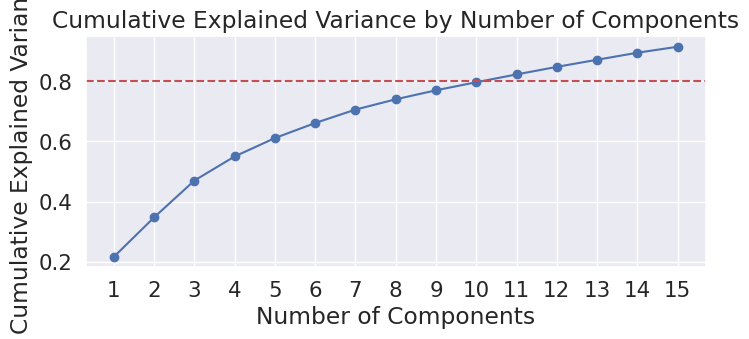

In [183]:
num_components = np.arange(1, 15 + 1)

plt.figure(figsize=(8, 3))
plt.plot(num_components, cum_evr, marker='o')

plt.axhline(y=0.8, color='r', linestyle='--')

# Add labels and title
plt.title('Cumulative Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.xticks(num_components)

# Display the plot
plt.show()


The graphical representation of Principal Component Analysis (PCA) illustrates the proportion of variance explained by varying numbers of components. In our specific case, the graph reveals that the initial 10 principal components can encapsulate approximately 80% of the data's total variance, while including 20 components accounts for the entire 100% variance. This insight sheds light on the dimensionality of our dataset and elucidates the trade-off between feature reduction and information preservation.

Opting for 10 components to elucidate 80% of the variance signifies that the core data patterns and crucial information are encapsulated within this reduced feature space. This dimensionality reduction carries several notable advantages. Firstly, it simplifies the data representation, enhancing visualization and interpretability. Secondly, it enhances computational efficiency, as computations are less demanding when operating in a lower-dimensional space. Lastly, it mitigates the challenges associated with the curse of dimensionality, particularly when the original dataset boasts a considerable number of features.

The decision to select 10 components stems from our objective to strike a balance between retaining adequate variance to capture essential data patterns while minimizing dimensionality. This constitutes a deliberate trade-off between simplicity and the potential loss of information. Opting for 20 components, which nears 100% variance, entails utilizing the entire feature set and retaining all available information. However, this approach might introduce redundancy and possibly noise, which may not align with the primary objectives of our analysis.

In [161]:
# Fitting and transforming the train and test data set using the updated PCA object with the ideal number of components
pca_final = PCA(n_components = 10)
X_pca = pca_final.fit_transform(X_train_scale)


In [162]:
# Import necessary libraries and perform train-test splits for original and PCA-transformed data
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X = train_data.drop(columns=['smoking'])
y = train_data['smoking']

y_pca = train_data['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, random_state=42, stratify=y_pca)



In [163]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

top_model_1 = rf_classifier
top_model_2 = extra_trees_classifier
top_model_3 = catboost_classifier

# Create a VotingClassifier
voting_classifier = VotingClassifier(
    estimators=[
        ('rf', top_model_1),
        ('et', top_model_2),
        ('cat', top_model_3)
    ],
    voting='soft'  # 'hard' for majority voting, 'soft' for weighted voting based on probabilities
)

# Fit the VotingClassifier on your training data
voting_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
voting_accuracy = voting_classifier.score(X_test, y_test)
print("Voting Classifier Accuracy:", voting_accuracy)


Voting Classifier Accuracy: 0.7899026741351397


In [164]:
ensemble_classifier = voting_classifier

In [165]:
estimator = ensemble_classifier
y_pred_test = estimator.predict(X_test)

In [166]:
confusion_matrix(y_test, y_pred_test)

array([[24150,  7060],
       [ 4230, 18297]])

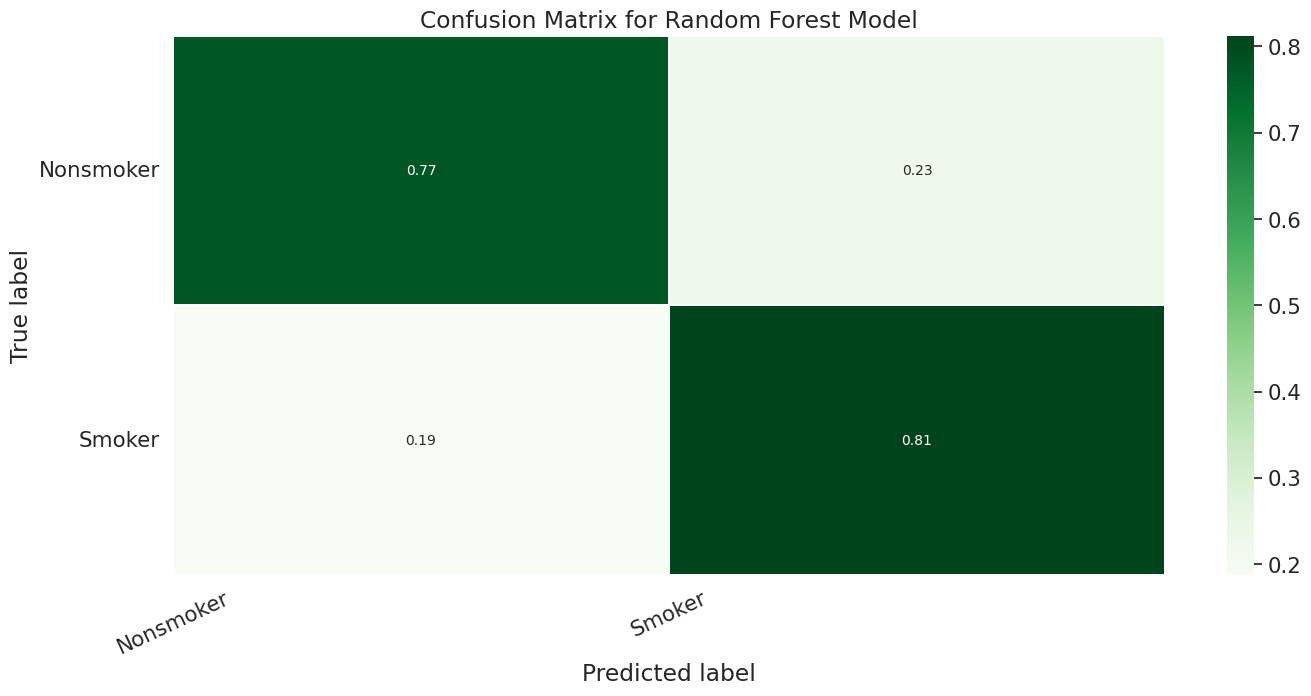

In [167]:

matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Nonsmoker', 'Smoker']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()


In [168]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81     31210
           1       0.72      0.81      0.76     22527

    accuracy                           0.79     53737
   macro avg       0.79      0.79      0.79     53737
weighted avg       0.80      0.79      0.79     53737



In [169]:

fpr, tpr, _ = roc_curve(y_test,  y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
roc_auc


0.7930078906913754

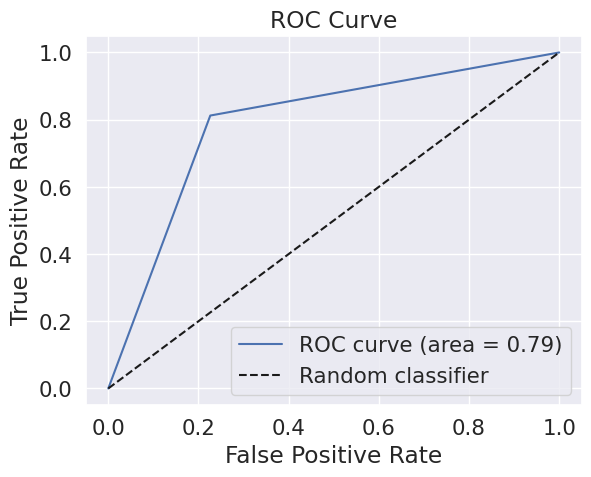

In [170]:

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


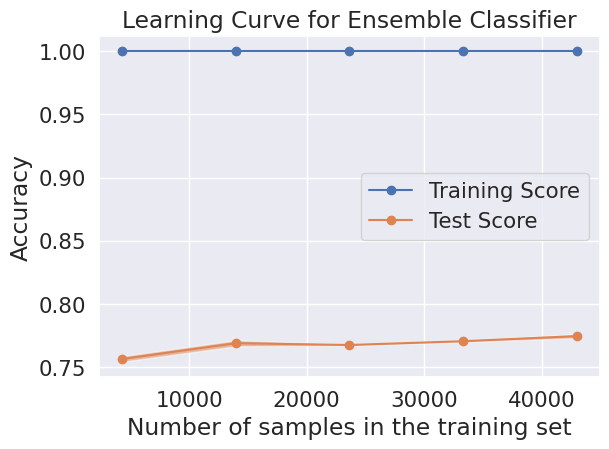

In [171]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
fig, ax = plt.subplots()

common_params = {
    "X": X_test,
    "y": y_test,
    "cv": ShuffleSplit(n_splits=2, train_size=0.8, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for Ensemble Classifier")
fig.tight_layout()

**Accounting for gender does slightly increase our accuracy**

In [172]:
# Sending to GPU if available
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

# Creating tensor from test and training data
X_train_tensor = torch.from_numpy(X_train[0:-1].values).float().to(device)
X_test_tensor = torch.from_numpy(X_test[0:-7].values).float().to(device)
y_train_tensor = torch.from_numpy(y_train[0:-1].values).float().to(device)
y_test_tensor = torch.from_numpy(y_test[0:-7].values).float().to(device)


In [173]:
# Verifying the number of features and rows within the tensors
print(X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape)

torch.Size([161210, 39]) torch.Size([53730, 39]) torch.Size([161210]) torch.Size([53730])


In [174]:
import torch.nn as nn
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return self.sigmoid(x)

In [175]:
import torch.optim as optim
# Defining the loss function and optimizer by which we update the model
net = NN(input_dim=(X_train_tensor.shape[1])).to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [176]:
# Training the neural network
n_epochs = 10
batch_size = 10
batch_start = torch.arange(0, len(X_train_tensor), batch_size)

best_bce = np.inf
bce_history = []
train_history = []

for epoch in range(n_epochs):
  for start in batch_start:
      X_batch = X_train_tensor[start: start + batch_size].to(device)
      y_batch = y_train_tensor[start: start + batch_size].to(device)
      y_pred = net(X_batch).to(device)
      loss = loss_fn(y_pred, y_batch.unsqueeze(dim=1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  train_history.append(float(loss))
  y_pred = net(X_test_tensor)
  bce = loss_fn(y_pred, y_test_tensor.unsqueeze(dim=1))
  bce = float(bce)
  print(bce)
  bce_history.append(bce)
  if bce < best_bce:
    best_bce = bce
  print("BEST BCE: ", best_bce)

0.49027761816978455
BEST BCE:  0.49027761816978455
0.4951540231704712
BEST BCE:  0.49027761816978455
0.4892690181732178
BEST BCE:  0.4892690181732178
0.4840892553329468
BEST BCE:  0.4840892553329468
0.4828697144985199
BEST BCE:  0.4828697144985199
0.4805859923362732
BEST BCE:  0.4805859923362732
0.4829592704772949
BEST BCE:  0.4805859923362732
0.4853479266166687
BEST BCE:  0.4805859923362732
0.48480167984962463
BEST BCE:  0.4805859923362732
0.48333773016929626
BEST BCE:  0.4805859923362732


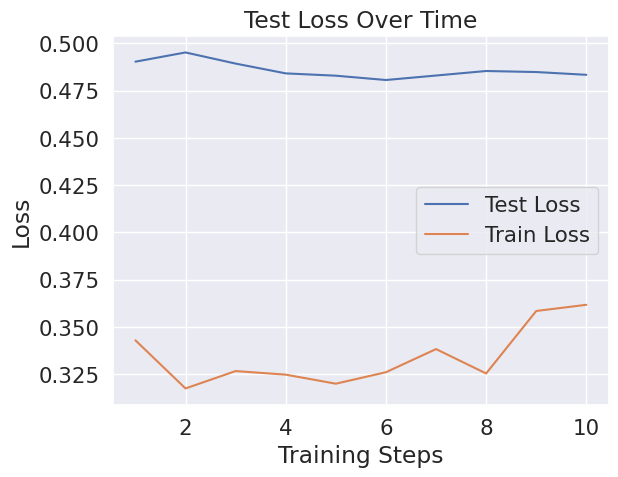

In [178]:
train_steps = range(1, len(bce_history) + 1)

plt.plot(train_steps, bce_history, label='Test Loss')
plt.plot(train_steps, train_history, label='Train Loss')

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Test Loss Over Time')
plt.show()

#Part 10. Conclusion

Conclusion for Smoking Prediction Project

In summary, our project to predict smoking status via biosignals revealed complexities and unexpected findings. Initially, we hypothesized that biomarkers like LDL, HDL, and cholesterol would be crucial predictors. However, our analysis showed that while some biosignals, such as hemoglobin, were significant, physical factors like height and gender emerged as unexpectedly strong predictors. Our dataset included a comprehensive range of features, from basic demographics to detailed biosignals and computed ratios like BMI and waist-to-height ratio.

We employed various models, including RF, XGBoost, CatBoost, LDA, QDA, Ridge, Extra Trees, and logistic regression, focusing on metrics like accuracy, precision, recall, and AUC. The RandomForest model struck an optimal balance between complexity and overfitting, standing out as the best individual model. Nevertheless, our top-performing solution was an ensemble of RandomForest, CatBoost, and Extra Trees, excelling across all metrics. Additionally, we found that accounting for both age and gender (confounding variables) increased accuracy of our models.

Our project faced significant challenges, particularly the long runtime for model training and the tendency of our models to overfit, which was a hurdle in achieving consistent accuracy across training and test sets. We addressed these issues by selecting less complex models and utilizing our conceptual understanding from the course.

For future work, exploring ways to reduce overfitting in our ensemble model seems promising. Introducing a more diverse range of models in the ensemble, especially non-tree-based ones, and fine-tuning our neural network, which underperformed, could enhance our predictions. We also see potential in further tuning the model parameters and exploring additional biosignals or external factors that could be linked to smoking habits.

Working on this project was a valuable learning experience, enhancing our collaboration and problem-solving skills. Each team member brought unique strengths to the project, contributing to a rich learning environment. Although we faced challenges with task delegation and collaboration, especially given the constraints of tools like Google Colab, the project was an excellent opportunity for team building and skill development. We extend our gratitude to Aashvi, our project TA, for her insightful feedback and guidance, which greatly contributed to our project's success.